# Introdução

Nesse notebook vamos implementar a GAN condicional (cGAN), que é uma modificação importante da GAN padrão que gerou várias formas diferentes delas serem usadas. Essa modificação consiste em incluir a informação do label no processo de geração. Com isso, o gerador é informado que ele deve não apenas gerar uma imaagem aleatória, mas também que essa imagem deve ser de determinada classe. Essa informação também é passada para o discriminador, e portanto ele tem o dever de verificar se aquela imagem é real sabendo que ela é de uma dada classe.

Como o processo de geração fica condicionado nos labels, essa técnica ficou conhecida como GAN condicional.

# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [ ]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [ ]:
# Setting predefined arguments.
args = {
    'epoch_num': 25,      # Number of epochs.
    'lr': 5e-4,           # Learning rate.
    'weight_decay': 5e-5, # L2 penalty.
    'num_workers': 8,     # Number of workers on data loader.
    'batch_size': 500,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'z_dim': 100,         # Dimension of z input vector.
    'num_samples': 10,    # Number of samples to be generated in evaluation.
    'num_classes': 10,    # Number of classes in dataset.
    'img_size': 28,       # Image size (H and W).
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
Size of training set: 60000 samples
Size of test set: 10000 samples


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Treinamento Adversarial Condicional

Podemos inserir o conceito de classe na nossa GAN ao passar o rótulo *c* de cada amostra para tanto $G$ quanto $D$. Dessa forma, $G$ vai otimizar a distribuição $p(x | z, c)$ usando o rótulo para gerar amostras da classe correta.

![CGANS](https://www.dropbox.com/s/gqtc5710dsrd4rh/GANs_Architecture_CGAN.png?dl=1)

Fazemos isso ao adicionar one-hot encodings de $c$ para cada amostra que são concatenados ao batch na dimensão 1 (tanto em $G$ quanto em $D$). Esse tipo de rede é conhecido como uma Conditional GAN (CGAN).

# Atividade Prática: Transformar nossa GAN em uma CGAN

1.   Implementar função *one_hot_encodings()*. Ela deve retornar 2 one-hot encodings: um para ser passado para $G$ e um para ser passado para $D$;
2.   Reaproveitar as arquiteturas de $G$ e $D$ anteriores e adaptar a *self.fc* de $G$ para receber o one-hot encoding das classes das amostras junto de $z$, ou seja, *args\['num_classes'\]* dimensões a mais de input para $G$. O módulo $self.conv$ de $D$ também deve ser adaptado para receber *args\['num_classes'\]* canais a mais;
3.   Complementar função *train()* para passar os encodings corretos para o *forward()* de cada rede;
4.   Lembrar de realizar a concatenação de ($z$, *c*) no *forward()* de $G$ e ($x$, *c*) no *forward()* de $D$.

# Computando one-hot encodings para labels

In [ ]:
# TO DO: Predefining one-hot encodings for G and D inputs.
def one_hot_encodings(labs, batch_size, num_classes, img_size):

    # TO DO: create array filled zeros with dimensions (B, #Classes).
    batch_one_hot_g = torch.zeros(batch_size,
                                  num_classes).to(args['device'])
    
    # TO DO: create array filled zeros with dimensions (B, #Classes, 28, 28).
    batch_one_hot_d = torch.zeros(batch_size,
                                  num_classes,
                                  img_size,
                                  img_size).to(args['device'])
    
    # TO DO: For each label in a sample in a batch, fill the corresponding
    #        other dimensions in batch_one_hot_g and batch_one_hot_d with 1.
    for i in range(labs.size(0)):

        # ...
        batch_one_hot_g[i, labs[i]].fill_(1.0)
        
        # ...
        batch_one_hot_d[i, labs[i], :, :].fill_(1.0)
    
    return batch_one_hot_g, batch_one_hot_d

# Sanity test for function one_hot_encodings().
labs = torch.randint_like(torch.zeros((4)), high=10, dtype=torch.long).to(args['device'])
print(labs)
one_hot_g, one_hot_d = one_hot_encodings(labs, 4, 10, 2)
print(one_hot_g)

tensor([8, 2, 2, 0], device='cuda:0')
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')


# Definindo o Gerador $G$

In [ ]:
# Adversarial Generator.
class Generator(nn.Module):
    
    def __init__(self,
                 input_dim=100,
                 output_channels=1,
                 img_size=28,
                 num_classes=10):
    
        super(Generator, self).__init__()
        
        self.input_dim = input_dim
        self.output_channels = output_channels
        self.img_size = img_size
        self.num_classes = num_classes

        # Define FC layers.
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.num_classes, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128 * (self.img_size // 4) * (self.img_size // 4)),
            nn.BatchNorm1d(128 * (self.img_size // 4) * (self.img_size // 4)),
            nn.ReLU(),
        )
        
        # Define deconv layers.
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_channels, 4, 2, 1),
            nn.Sigmoid(),
        )
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, c):
        
        # TO DO: Concat x and c.
        x = torch.cat([x, c], 1)
        
        # Forward.
        x = self.fc(x)
        
        x = x.view(-1, 128, (self.img_size // 4), (self.img_size // 4))
        
        x = self.deconv(x)

        return x

# Instantiating G.
net_G = Generator(input_dim=args['z_dim']).to(args['device'])

# Printing architecture.
print(net_G)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)


# Definindo o Discriminador $D$

In [ ]:
# Adversarial Discriminator.
class Discriminator(nn.Module):
    
    def __init__(self,
                 input_channels=1,
                 output_channels=1,
                 input_size=28,
                 num_classes=10):
        
        super(Discriminator, self).__init__()
        
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.input_size = input_size
        self.num_classes = num_classes
        
        # Define conv layers.
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_channels + self.num_classes,
                      64,
                      kernel_size=(4, 4),
                      stride=2,
                      padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,
                      128,
                      kernel_size=(4, 4),
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        # Define FC layers.
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, self.output_channels),
            nn.Sigmoid(),
        )
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
                
    def forward(self, x, c):
        
        x = torch.cat([x, c], 1)
        
        x = self.conv(x)
        
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        
        x = self.fc(x)

        return x

# Instantiating D.
net_D = Discriminator().to(args['device'])

# Printing architecture.
print(net_D)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


# Definindo o otimizadores

In [ ]:
# Defining optimizer for G.
opt_G = optim.Adam(net_G.parameters(),
                   lr=args['lr'],
                   weight_decay=args['weight_decay'])

# Defining optimizer for D.
opt_D = optim.Adam(net_D.parameters(),
                   lr=args['lr'],
                   weight_decay=args['weight_decay'])

# Definindo um Scheduler para os Learning Rates

In [ ]:
# Defining lr scheduler.
scheduler_G = optim.lr_scheduler.StepLR(opt_G, args['epoch_num'] // 5, 0.5)
scheduler_D = optim.lr_scheduler.StepLR(opt_D, args['epoch_num'] // 5, 0.5)

# Definindo a loss composta

In [ ]:
# Defining adversarial loss.
criterion = nn.BCELoss().to(args['device'])

# Criando funções para Treino e Teste

In [ ]:
# Training procedure.
def train(train_loader,
          net_G, net_D,
          criterion,
          opt_G, opt_D,
          epoch,
          train_loss_G, train_loss_D):
    
    tic = time.time()
    
    # Predefining ones and zeros for batches.
    y_real = torch.ones(args['batch_size'], 1).to(args['device'])
    y_fake = torch.zeros(args['batch_size'], 1).to(args['device'])

    # Setting networks for training mode.
    net_D.train()
    net_G.train()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
        
        # Obtaining images and labels for batch.
        x, labs = batch_data
        
        # Creating random vector z.
        z = torch.rand((args['batch_size'], args['z_dim']))
        
        # TO DO: Generating random values for batch fake_labs.
        fake_labs = torch.randint_like(labs, high=10, dtype=torch.long).to(args['device'])
        
        # Casting to correct device (x and z).
        x = x.to(args['device'])
        z = z.to(args['device'])
        
        labs = labs.to(args['device'])
        fake_labs = fake_labs.to(args['device'])
        
        
        # TO DO: Computing one-hot encodings for batch labs and fake_labs.
        one_hot_g_fake, one_hot_d_fake = one_hot_encodings(fake_labs,
                                                           args['batch_size'],
                                                           args['num_classes'],
                                                           args['img_size'])
        
        one_hot_g_real, one_hot_d_real = one_hot_encodings(labs,
                                                           args['batch_size'],
                                                           args['num_classes'],
                                                           args['img_size'])
        
        ###############
        # Updating D. #
        ###############
        
        # Clearing the gradients of D optimizer.
        opt_D.zero_grad()

        # Forwarding real data.
        D_real = net_D(x, one_hot_d_real) # Through D.
        
        # Computing loss for real data.
        D_real_loss = criterion(D_real, y_real)

        # Forwarding fake data.
        G_out = net_G(z, one_hot_g_fake) # Through G.
        D_fake = net_D(G_out.detach(), one_hot_d_fake) # Through D.
        
        # Computing loss for fake data.
        D_fake_loss = criterion(D_fake, y_fake)

        # Computing total loss for D.
        D_loss = D_real_loss + D_fake_loss
        
        # Computing backpropagation for D.
        D_loss.backward()
        
        # Taking step in D optimizer.
        opt_D.step()

        ###############
        # Updating G. #
        ###############
        
        # Clearing the gradients of G optimizer.
        opt_G.zero_grad()

        # Forwarding fake data.
        G_out = net_G(z, one_hot_g_fake) # Through G.
        D_fake = net_D(G_out, one_hot_d_fake) # Through D.
        
        # Computing loss for G.
        G_loss = criterion(D_fake, y_real)
        
        # Computing backpropagation for G.
        G_loss.backward()
        
        # Taking step in G optimizer.
        opt_G.step()
        
        
        # Updating lists.
        train_loss_G.append(G_loss.data.item())
        train_loss_D.append(D_loss.data.item())

    toc = time.time()
    
    # Printing training epoch loss.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [training time %.2f]' % (
        epoch, (toc - tic)))
    print('-------------------------------------------------------------------')
    
    if epoch % args['print_freq'] == 0:
        
        # Plotting losses.
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))

        ax[0].plot(np.asarray(train_loss_G), 'r-', label='G loss')
        ax[0].legend()
        
        ax[1].plot(np.asarray(train_loss_D), 'b--', label='D loss')
        ax[1].legend()

        plt.show()
        
    return train_loss_G, train_loss_D

In [ ]:
# Evaluating procedure.
def evaluate(net_G, criterion, epoch):
    
    # Setting networks for training mode.
    net_D.eval()
    net_G.eval()
    
    fake_labs = torch.randint_like(torch.zeros((args['num_samples'] * args['num_samples'])),
                                   high=10,
                                   dtype=torch.long).to(args['device'])
    
    one_hot_g, one_hot_d = one_hot_encodings(fake_labs,
                                             args['num_samples'] * args['num_samples'],
                                             args['num_classes'],
                                             args['img_size'])
    
    # Creating random vector z.
    z = torch.rand((args['num_samples'] * args['num_samples'], args['z_dim']))
    
    # Casting to correct device.
    z = z.to(args['device'])
    
    # Generating new samples.
    G_out = net_G(z, one_hot_g)
    
    # Plotting.
    fig, ax = plt.subplots(args['num_samples'],
                           args['num_samples'],
                           figsize=(20, 20))
    
    for i in range(args['num_samples']):
        
        for j in range(args['num_samples']):
            
            sample = G_out[j * args['num_samples'] + i]
            
            ax[j, i].imshow(sample.detach().cpu().numpy().squeeze(),
                            cmap=plt.get_cmap('gray'))
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            ax[j, i].set_title('Label: ' + str(fake_labs[j * args['num_samples'] + i].item()))
            
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [training time 32.97]
-------------------------------------------------------------------


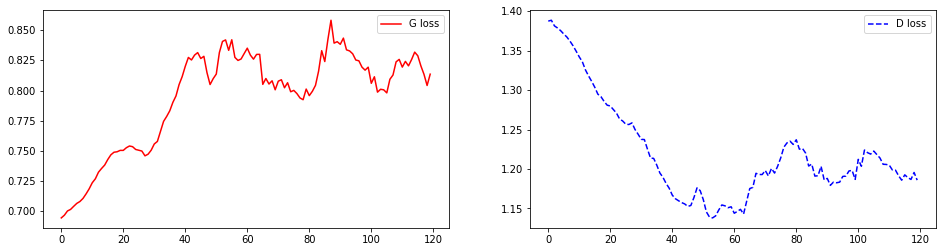

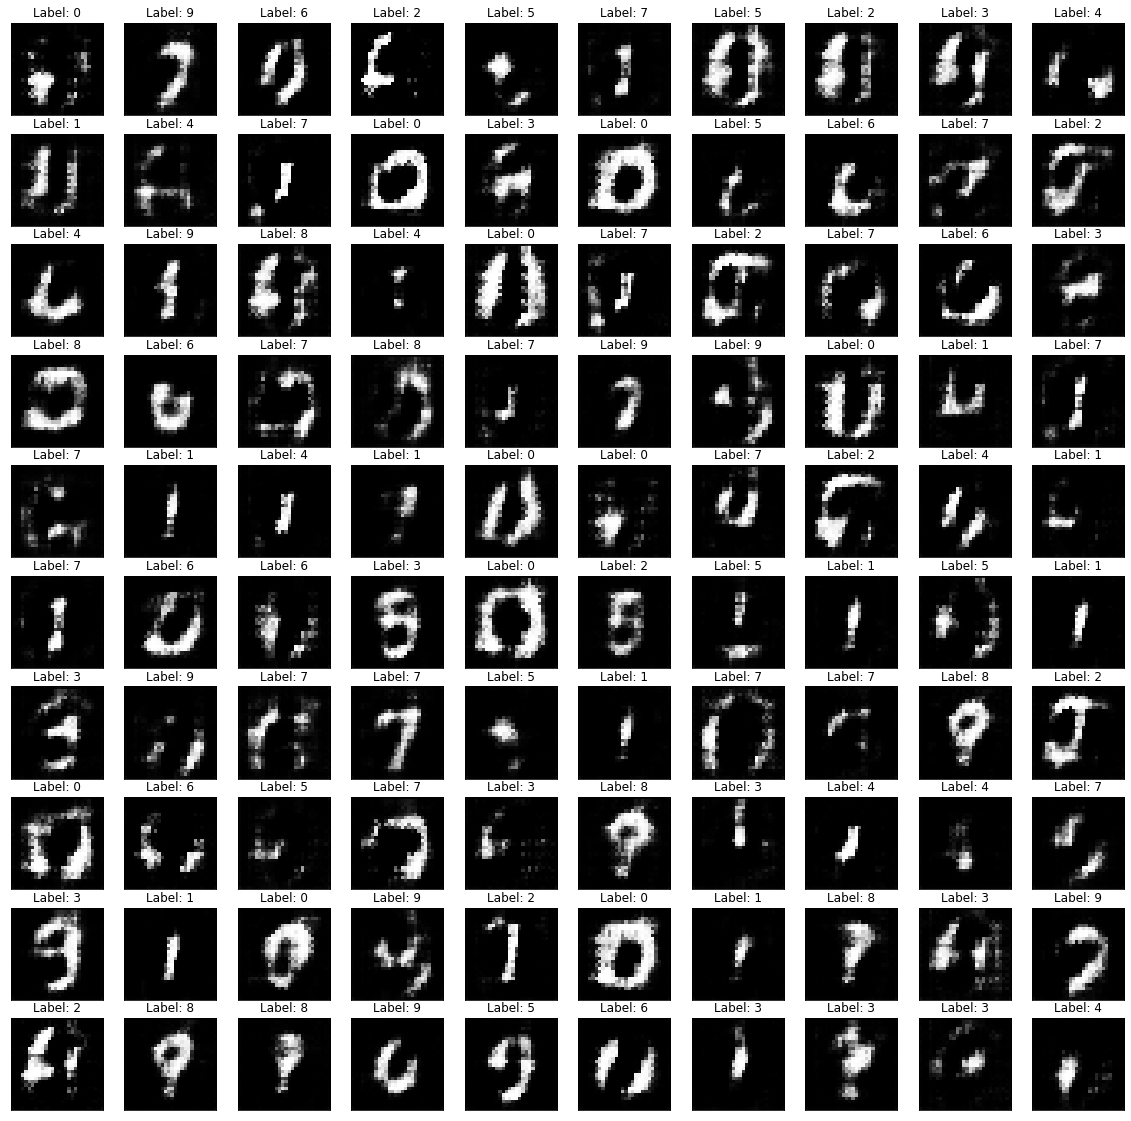

-------------------------------------------------------------------
[epoch 2], [training time 33.01]
-------------------------------------------------------------------


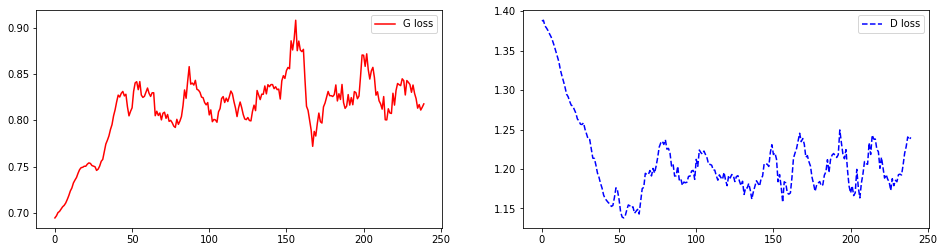

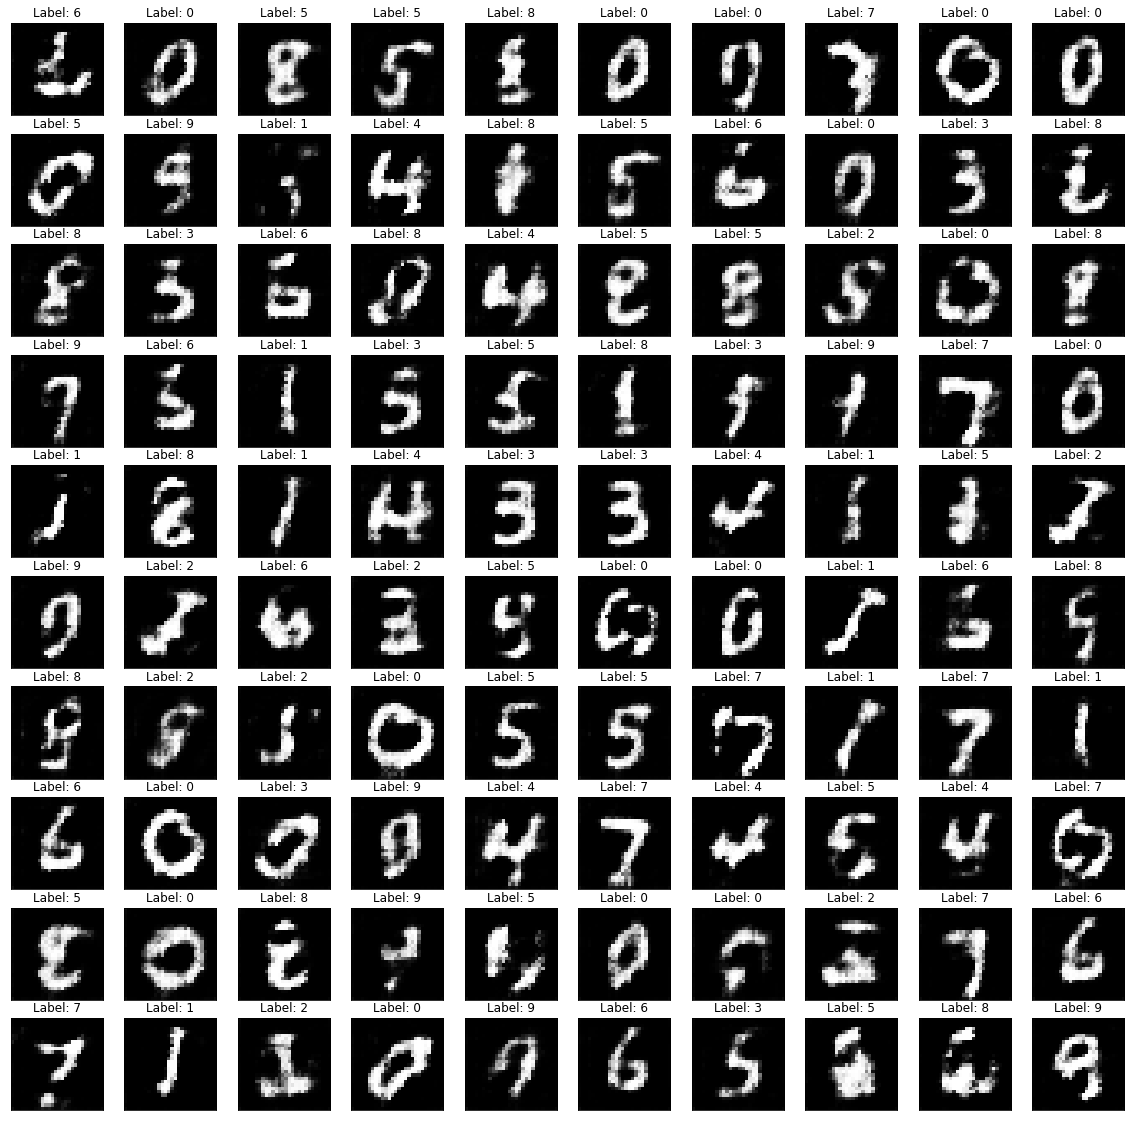

-------------------------------------------------------------------
[epoch 3], [training time 32.90]
-------------------------------------------------------------------


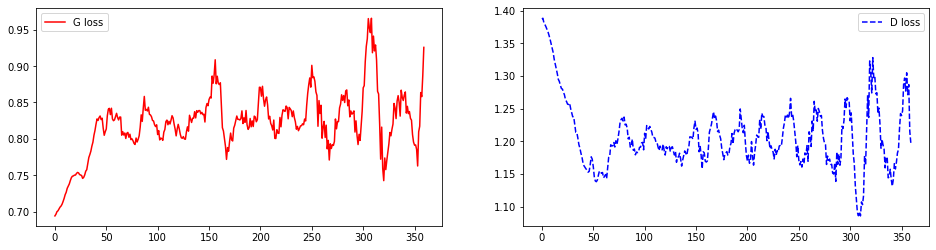

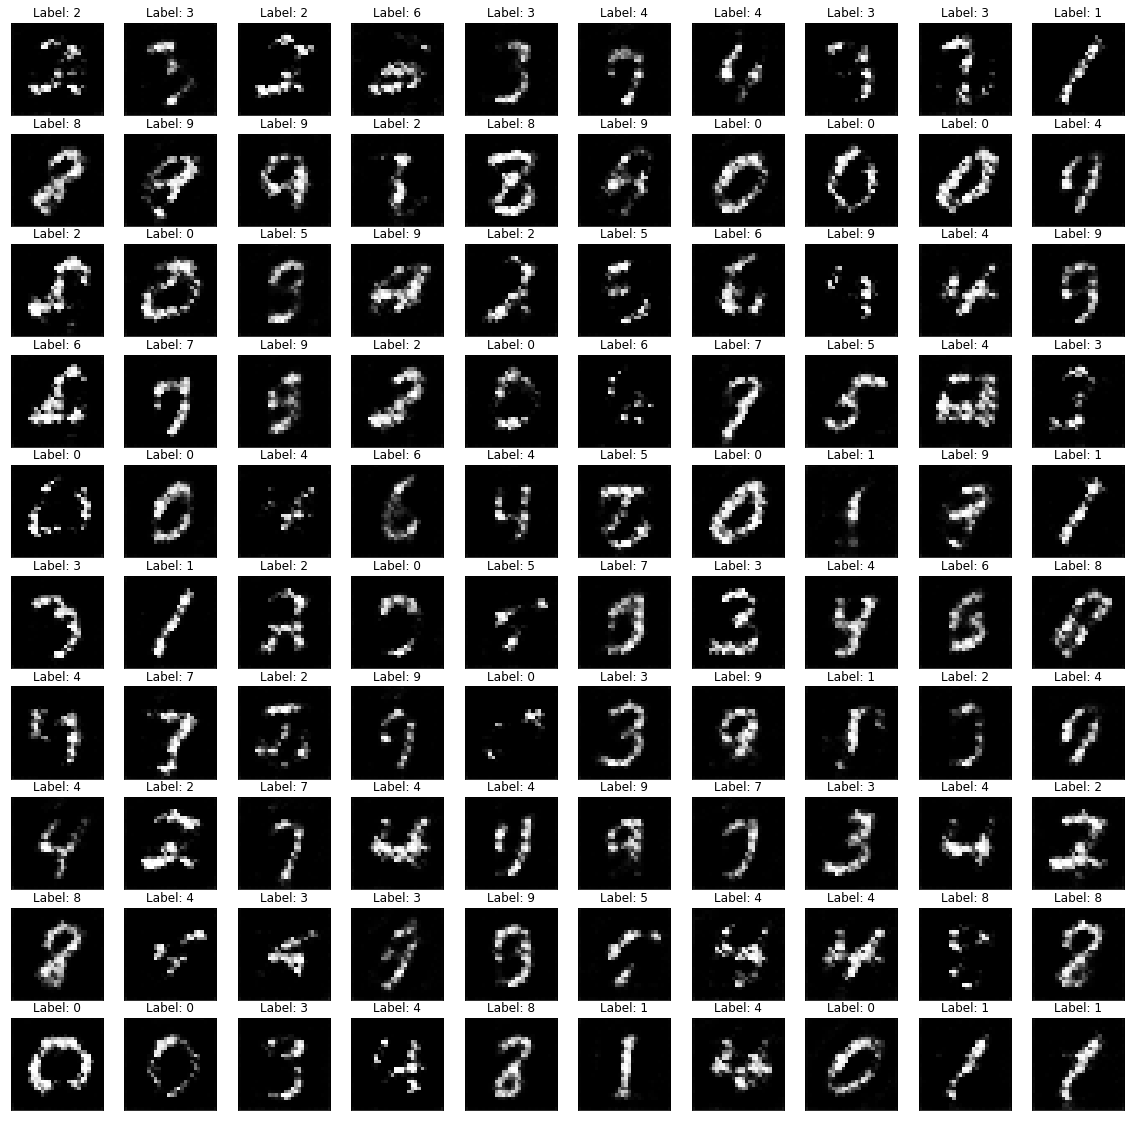

-------------------------------------------------------------------
[epoch 4], [training time 33.02]
-------------------------------------------------------------------


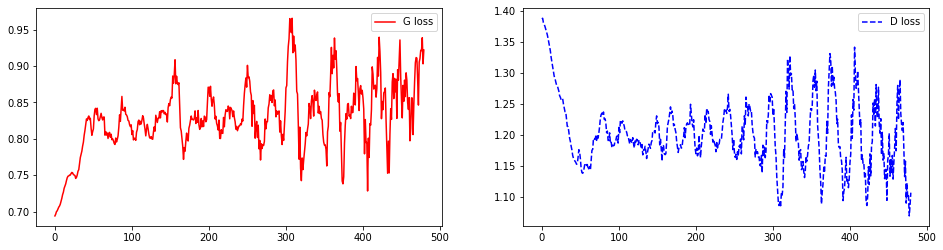

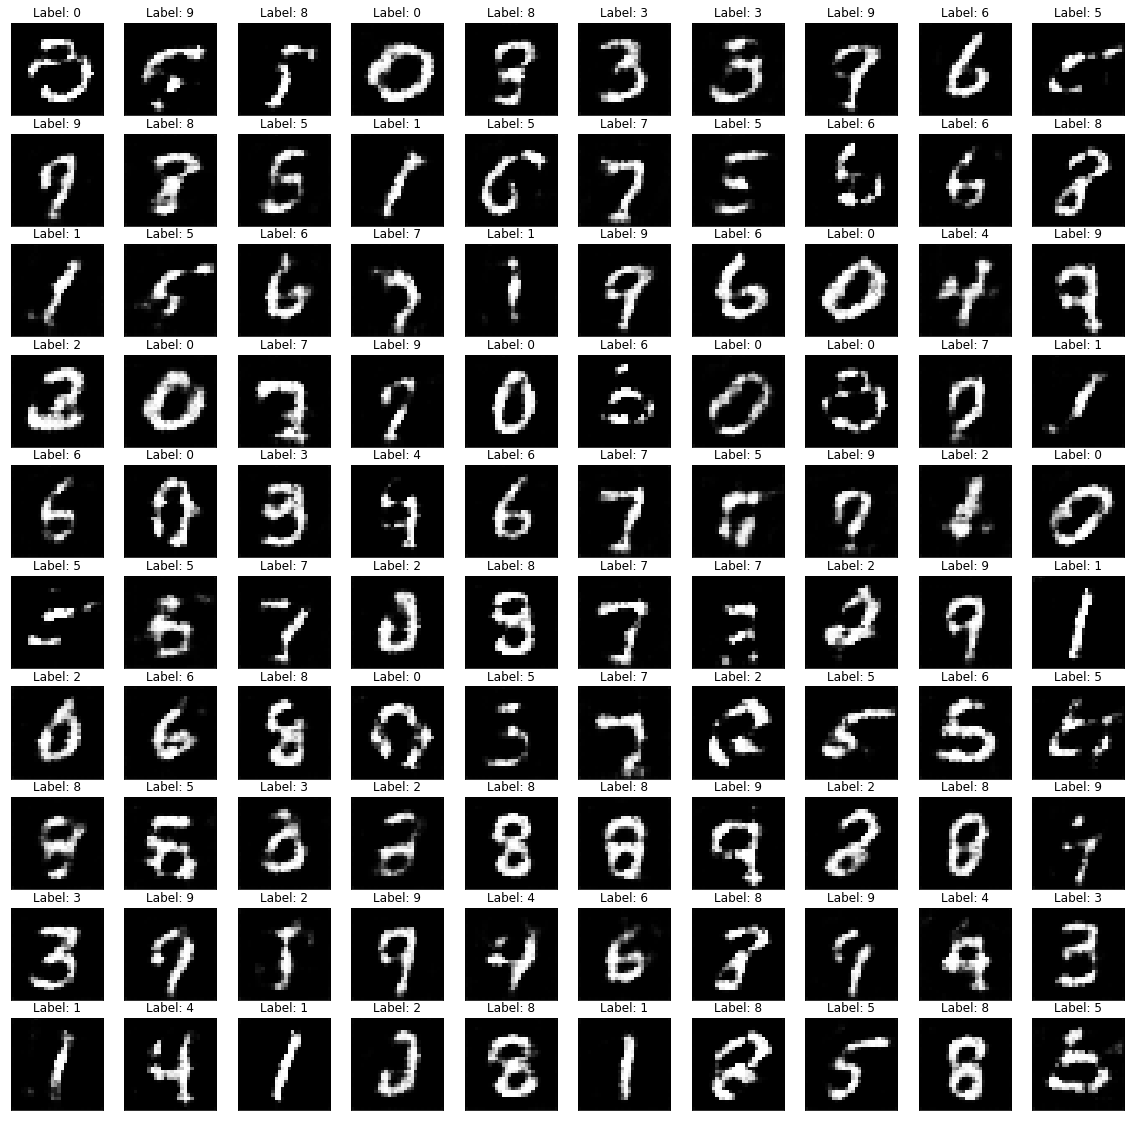

-------------------------------------------------------------------
[epoch 5], [training time 33.10]
-------------------------------------------------------------------


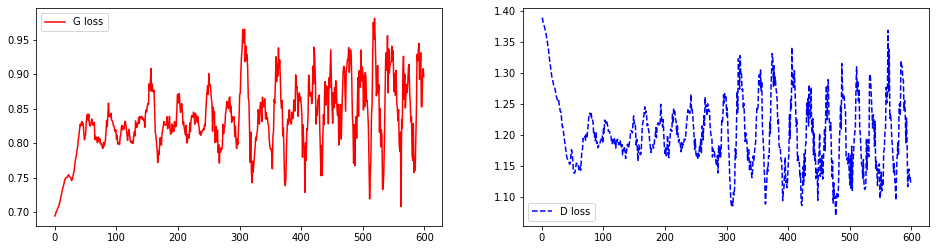

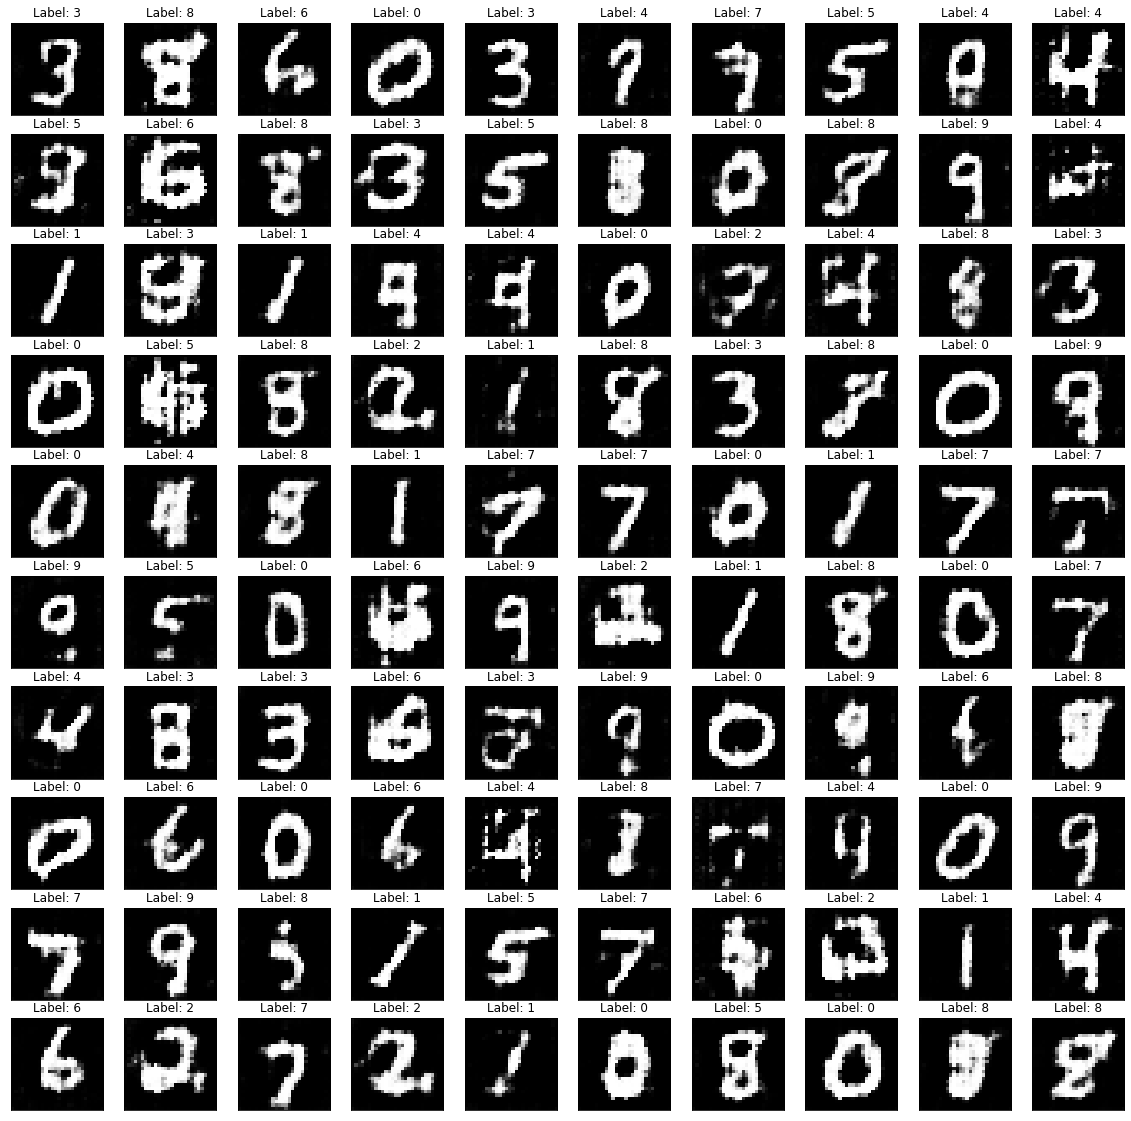

-------------------------------------------------------------------
[epoch 6], [training time 33.16]
-------------------------------------------------------------------


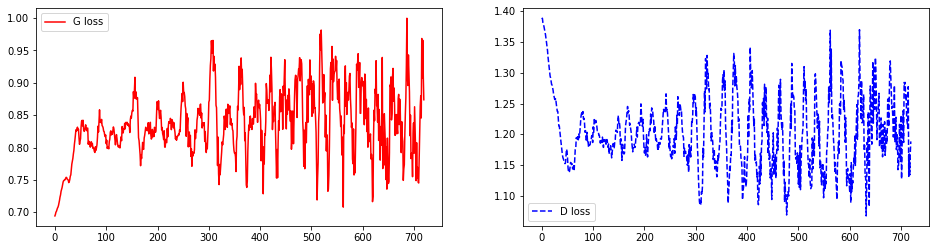

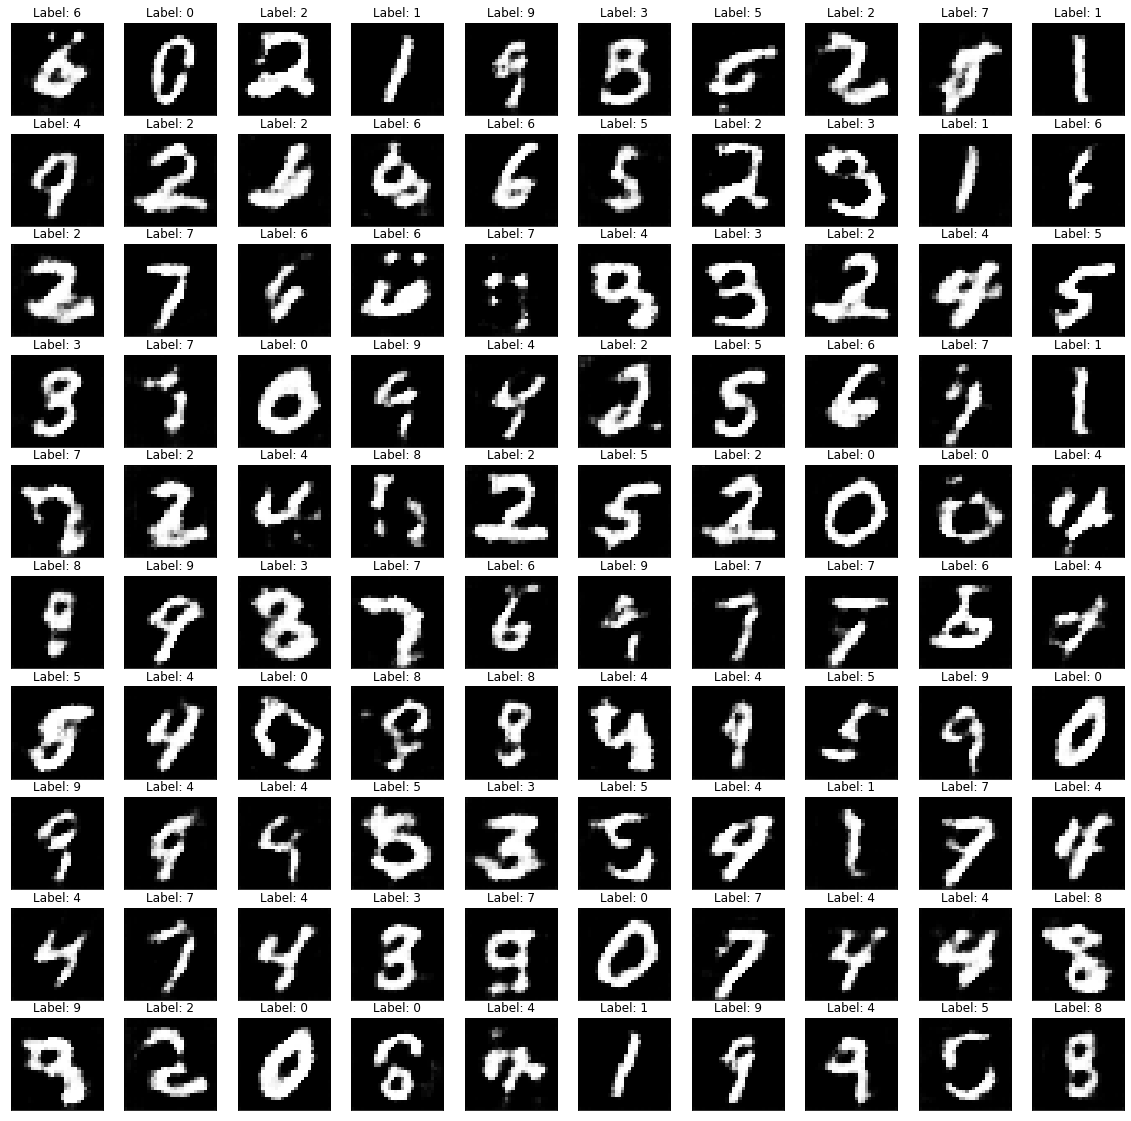

-------------------------------------------------------------------
[epoch 7], [training time 33.07]
-------------------------------------------------------------------


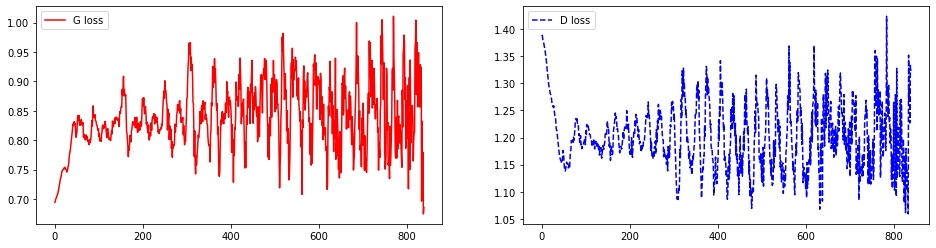

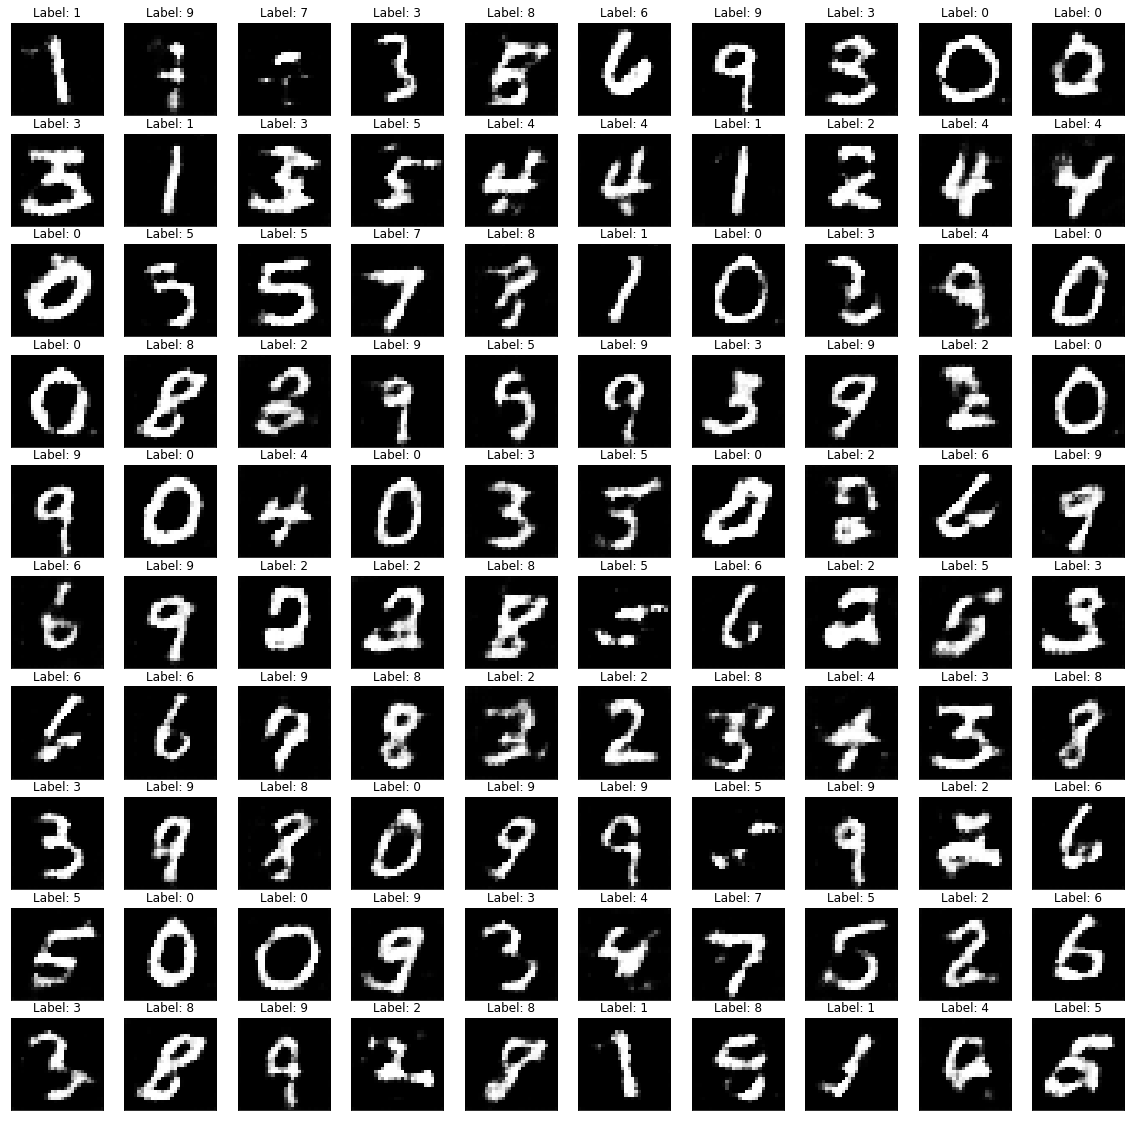

-------------------------------------------------------------------
[epoch 8], [training time 33.29]
-------------------------------------------------------------------


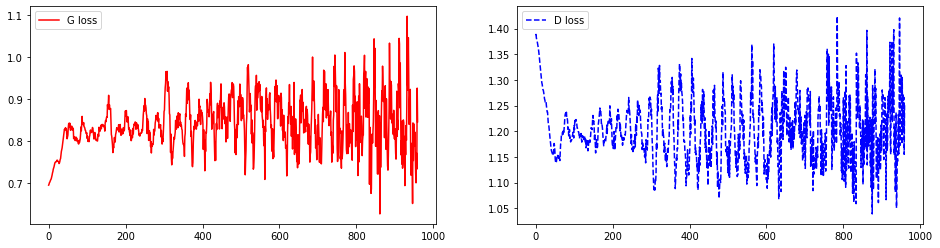

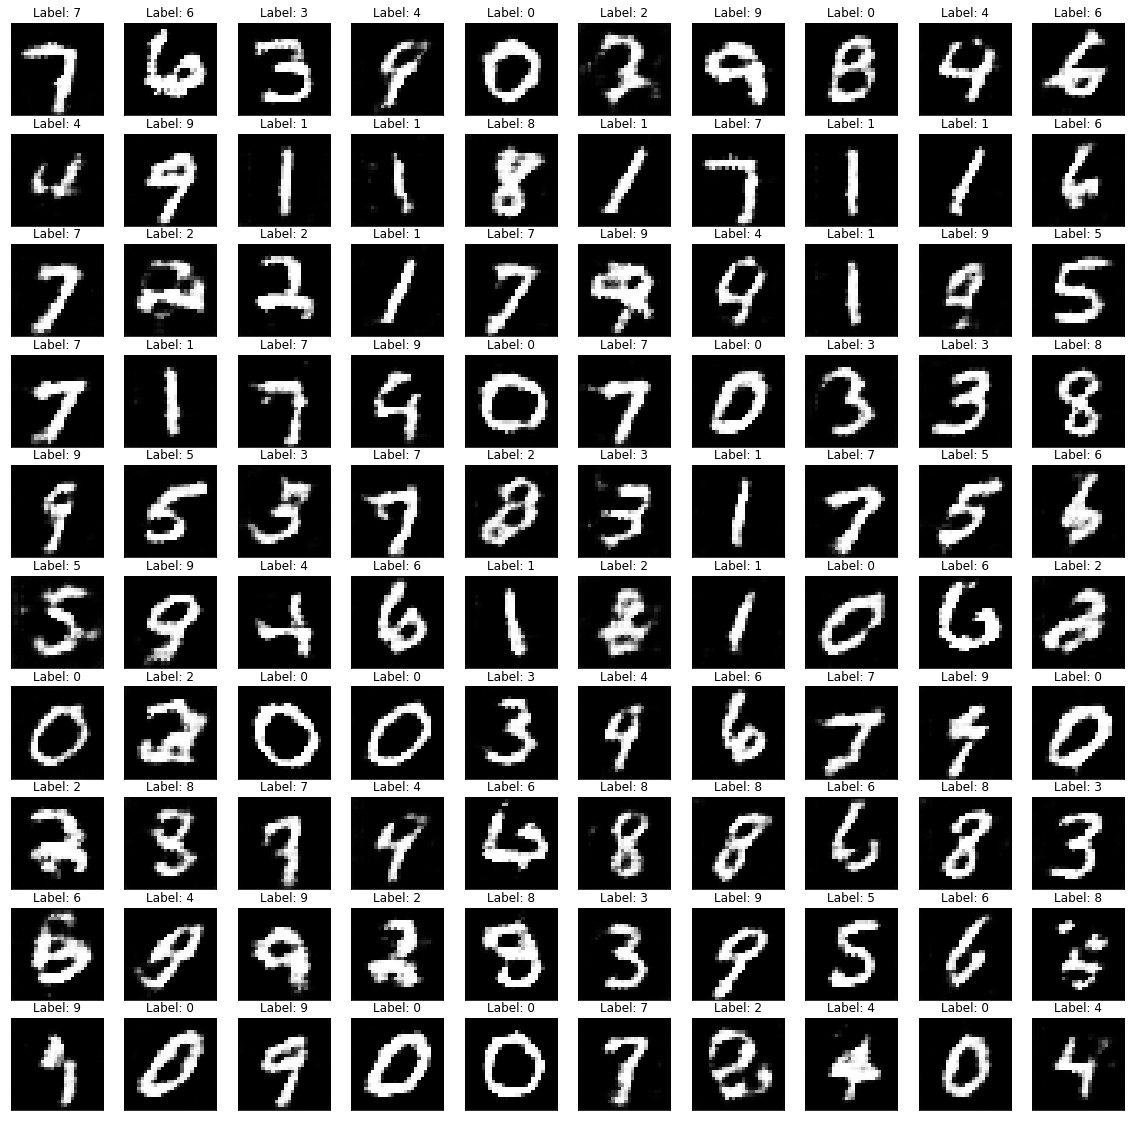

-------------------------------------------------------------------
[epoch 9], [training time 33.13]
-------------------------------------------------------------------


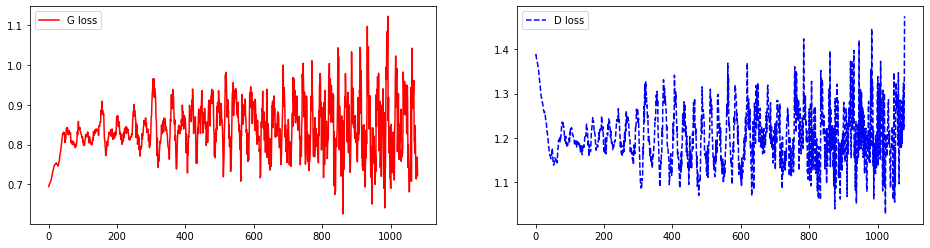

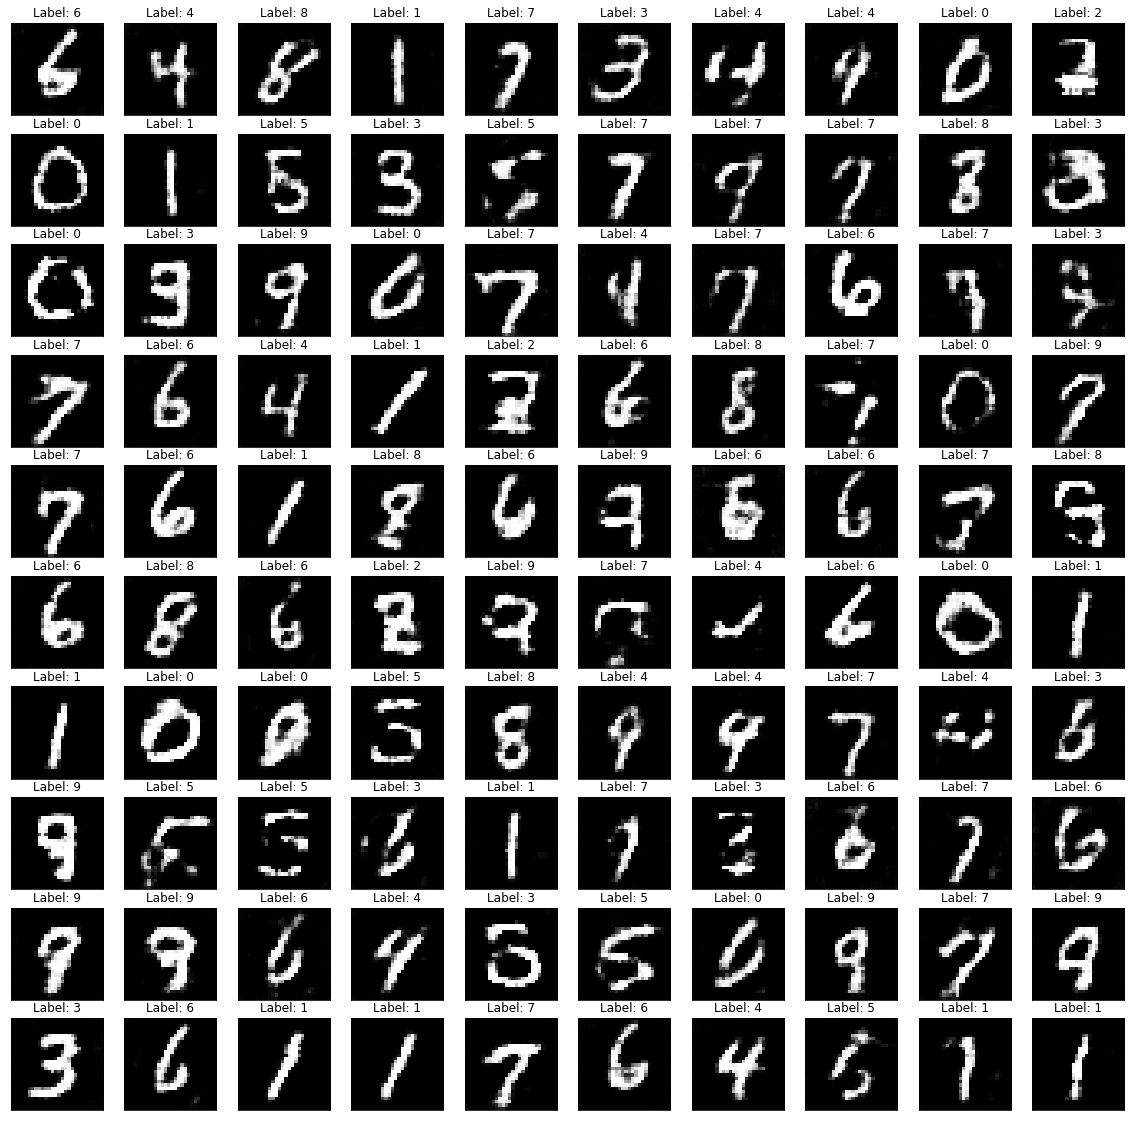

-------------------------------------------------------------------
[epoch 10], [training time 33.61]
-------------------------------------------------------------------


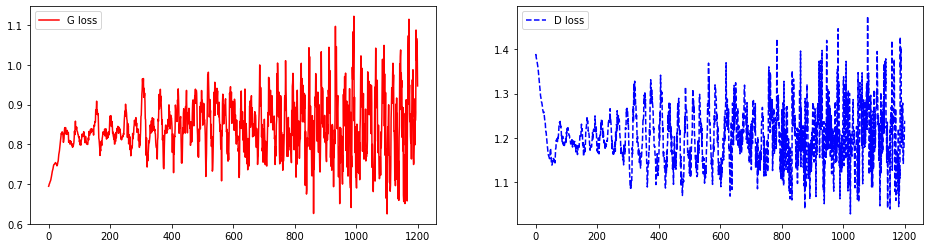

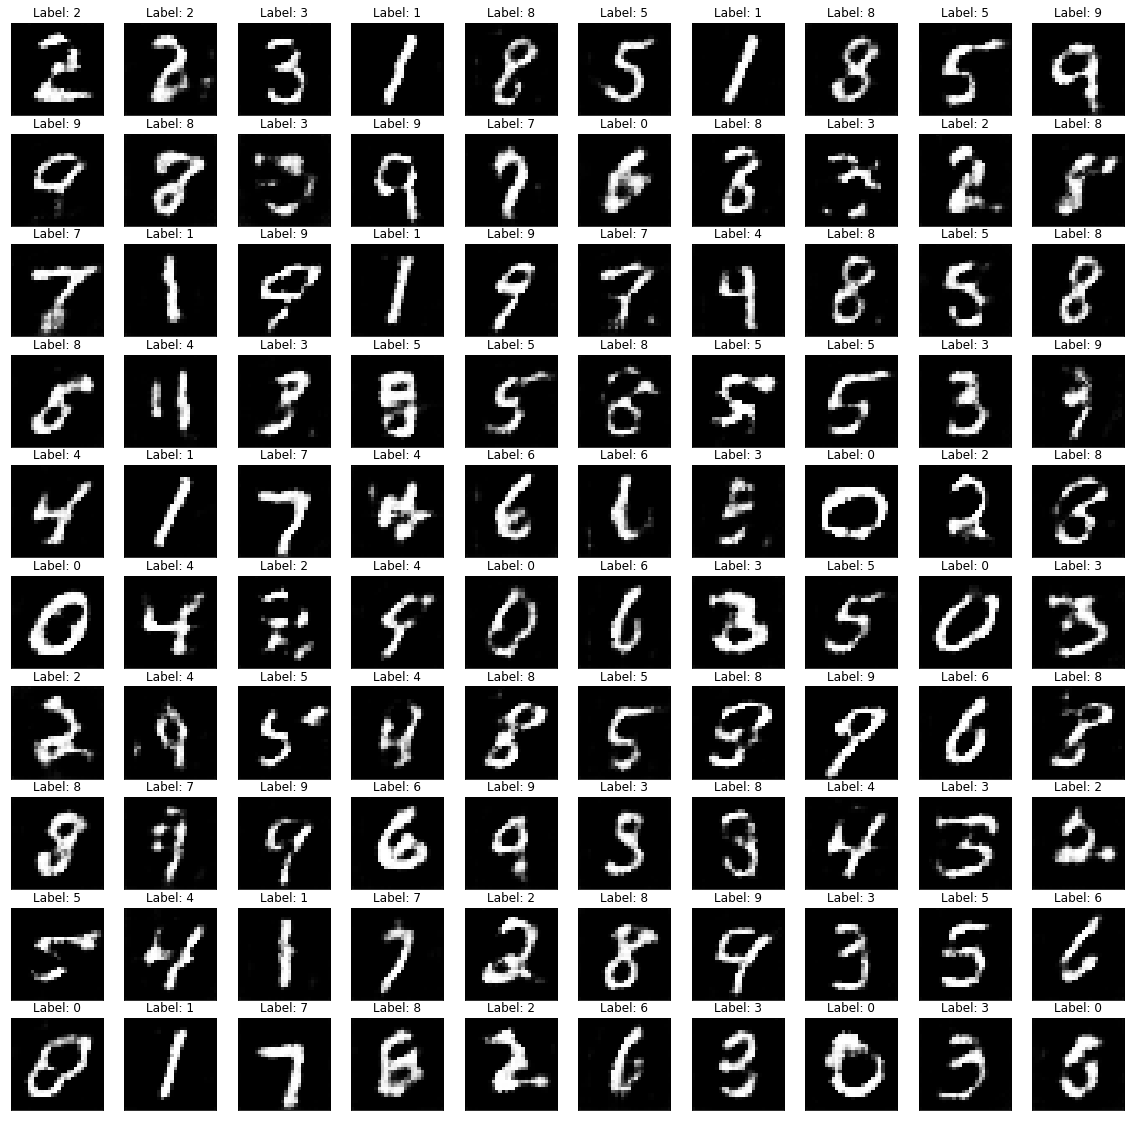

-------------------------------------------------------------------
[epoch 11], [training time 33.42]
-------------------------------------------------------------------


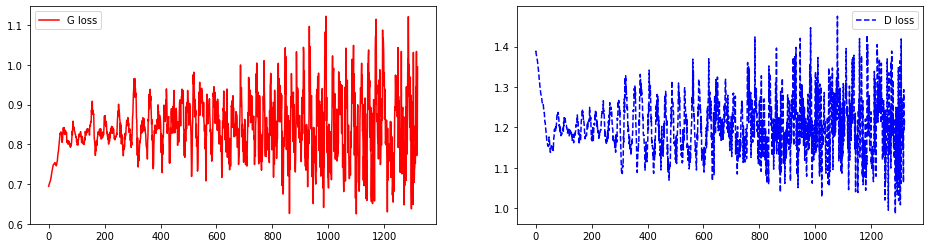

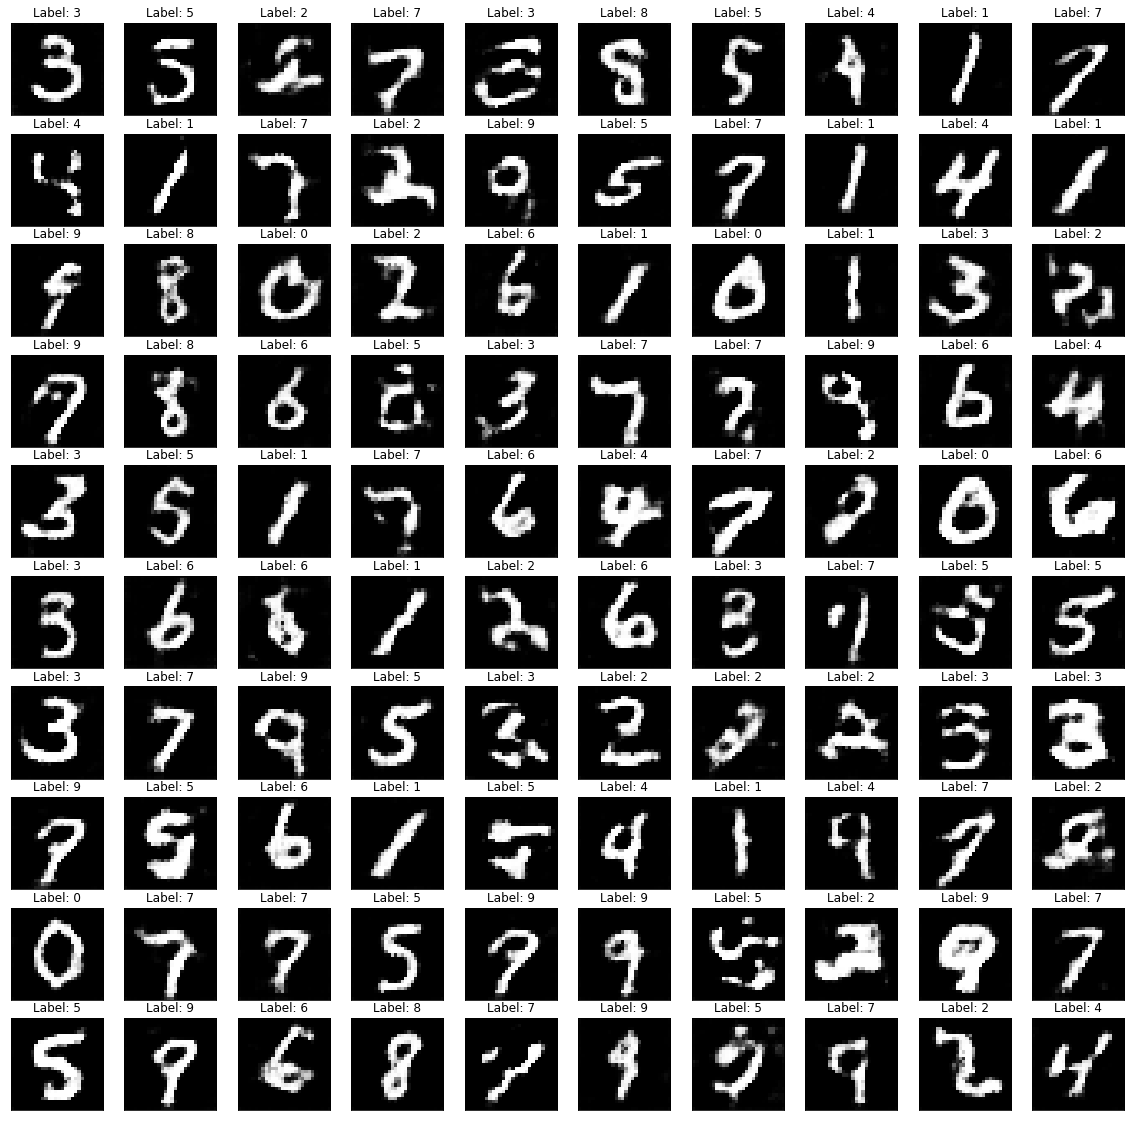

-------------------------------------------------------------------
[epoch 12], [training time 33.48]
-------------------------------------------------------------------


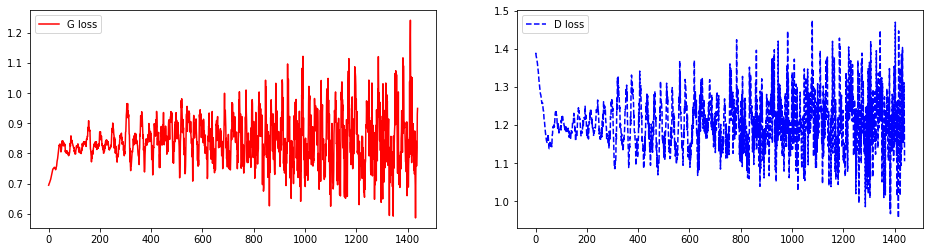

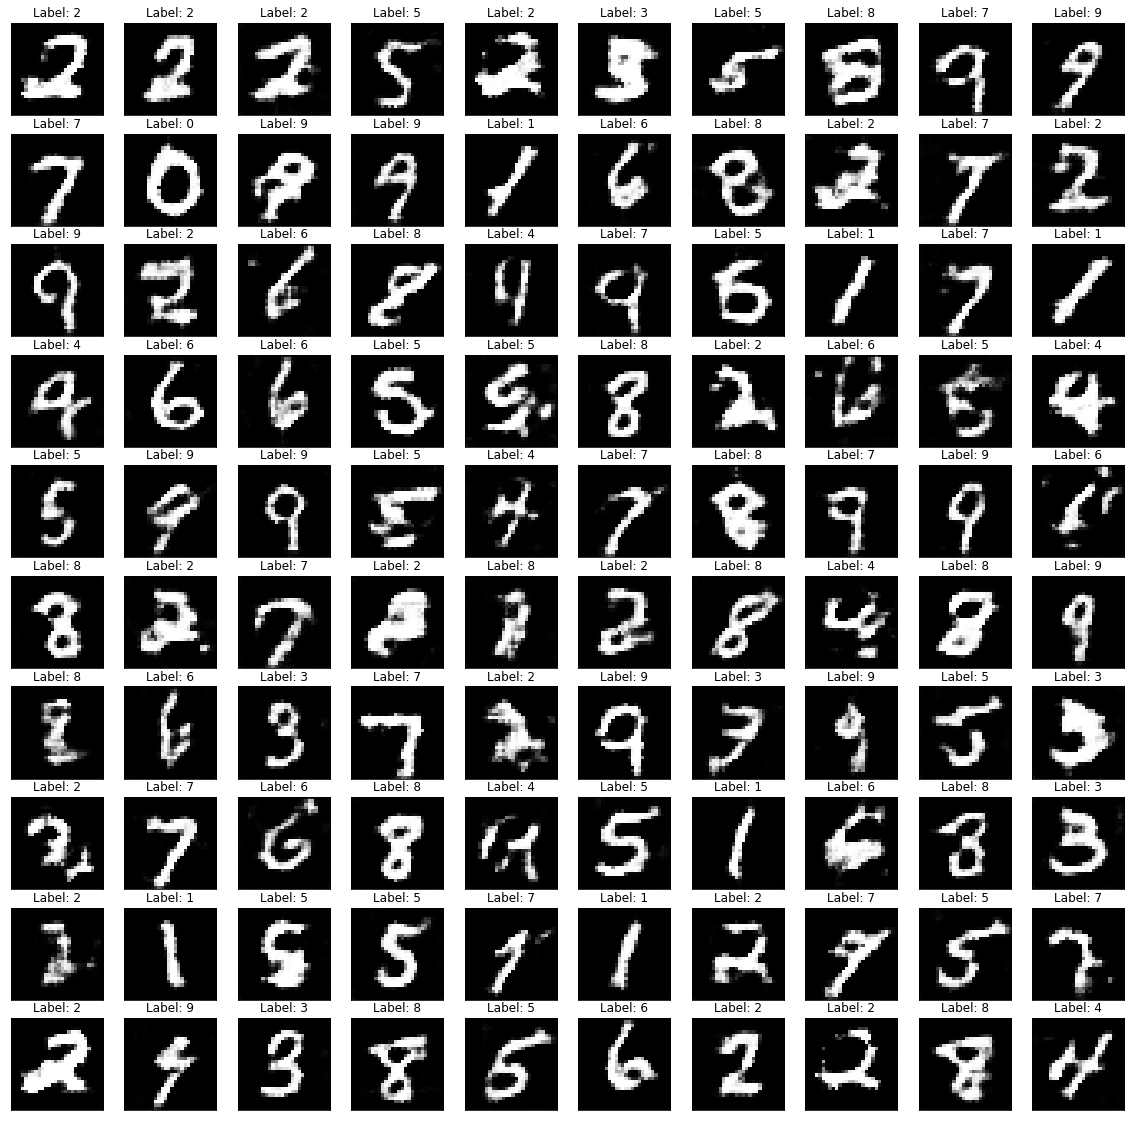

-------------------------------------------------------------------
[epoch 13], [training time 32.87]
-------------------------------------------------------------------


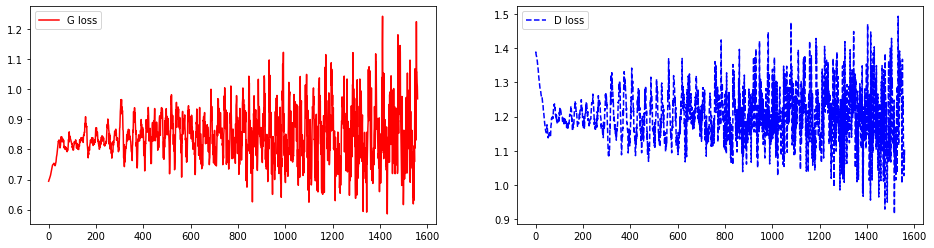

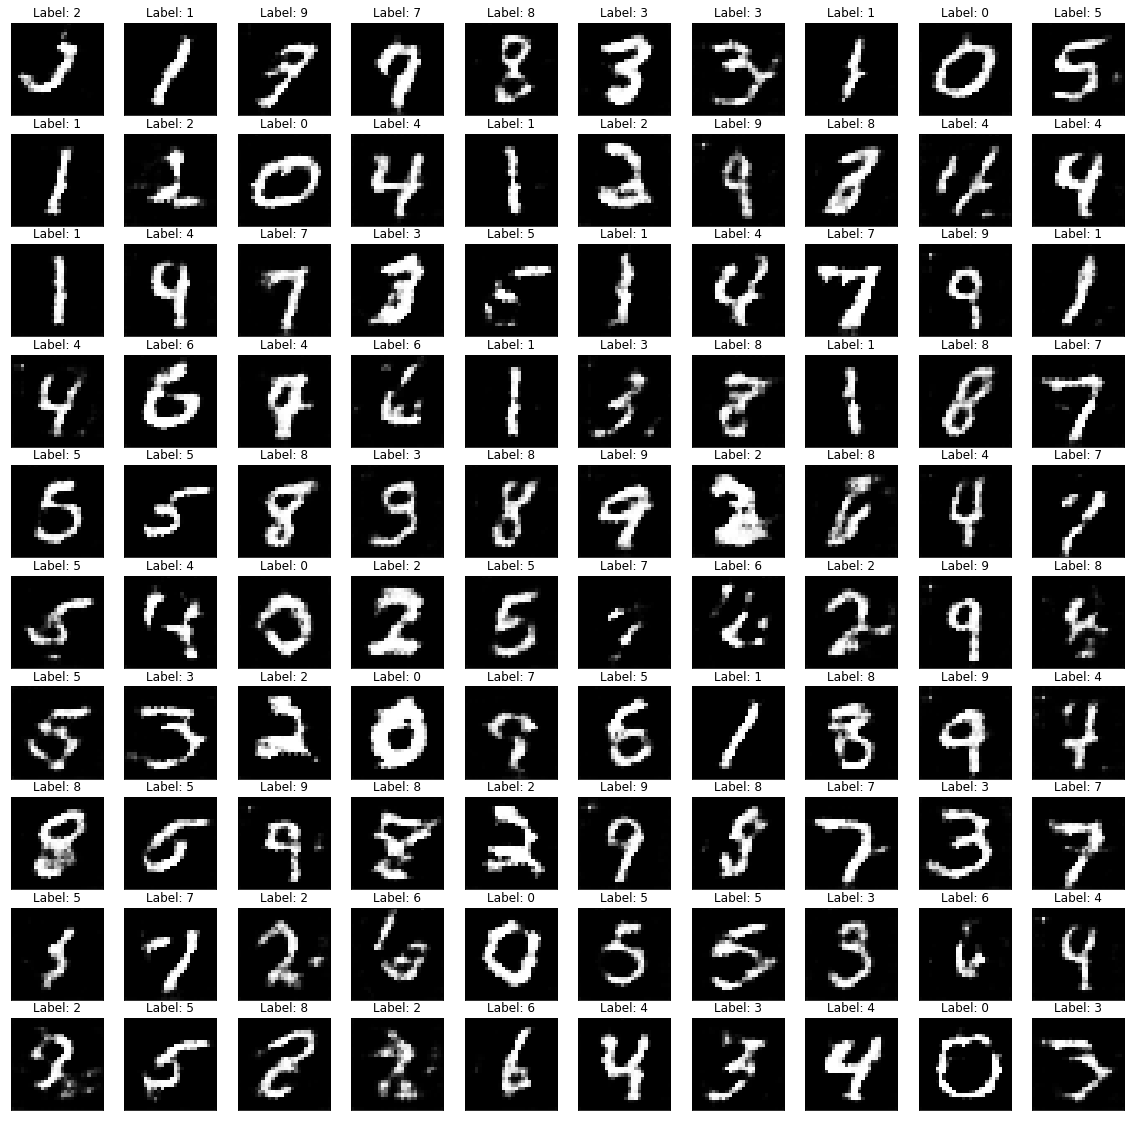

-------------------------------------------------------------------
[epoch 14], [training time 32.98]
-------------------------------------------------------------------


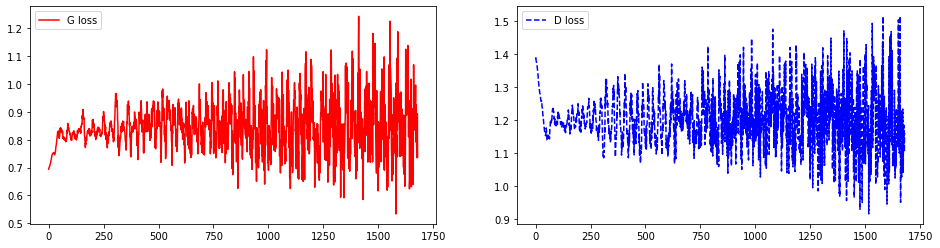

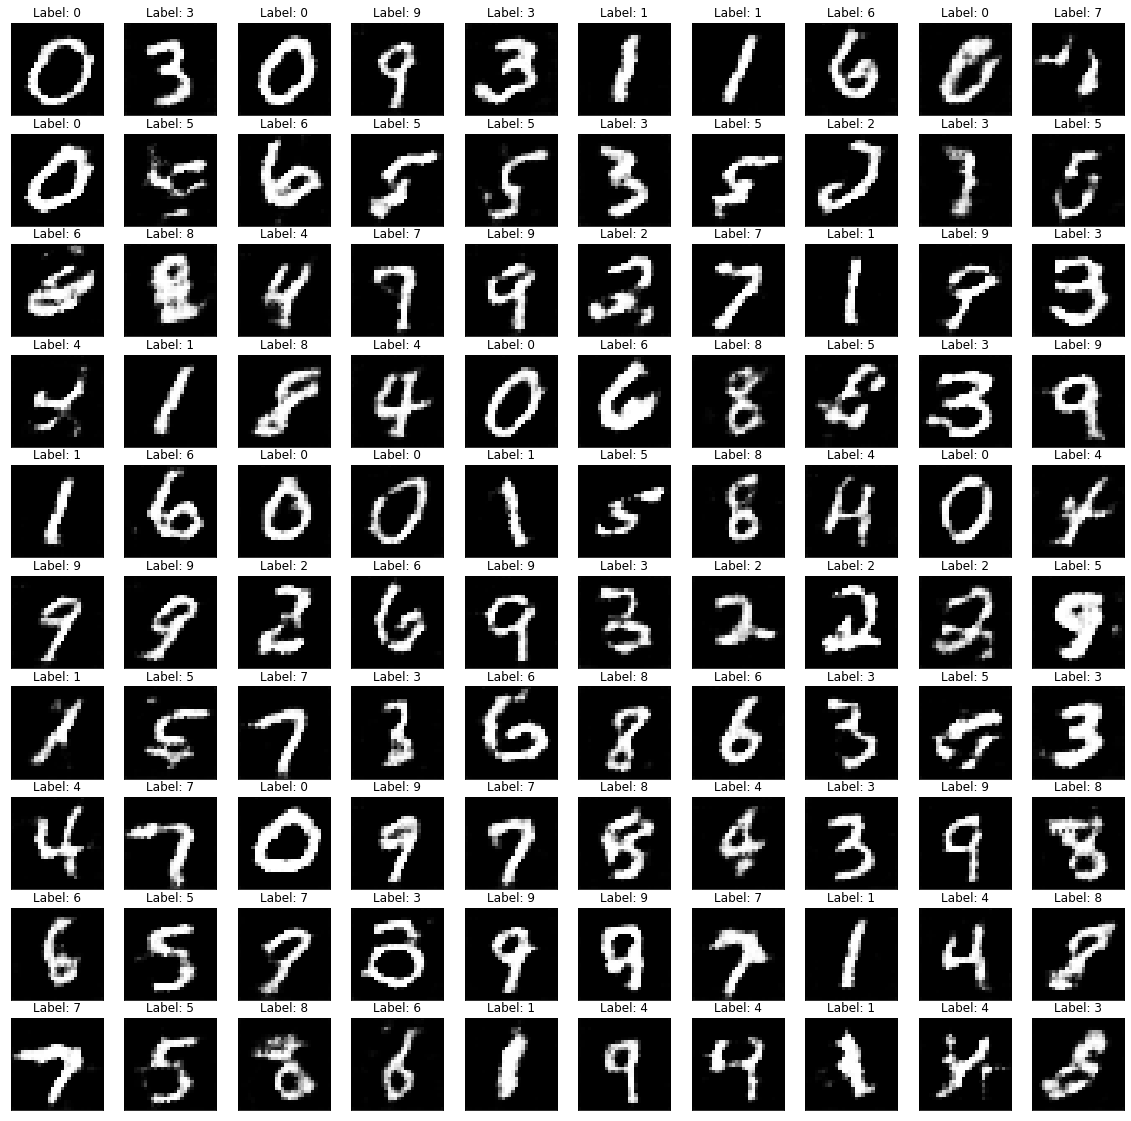

-------------------------------------------------------------------
[epoch 15], [training time 32.89]
-------------------------------------------------------------------


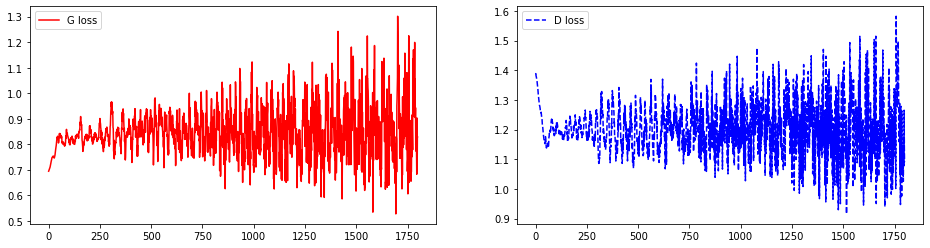

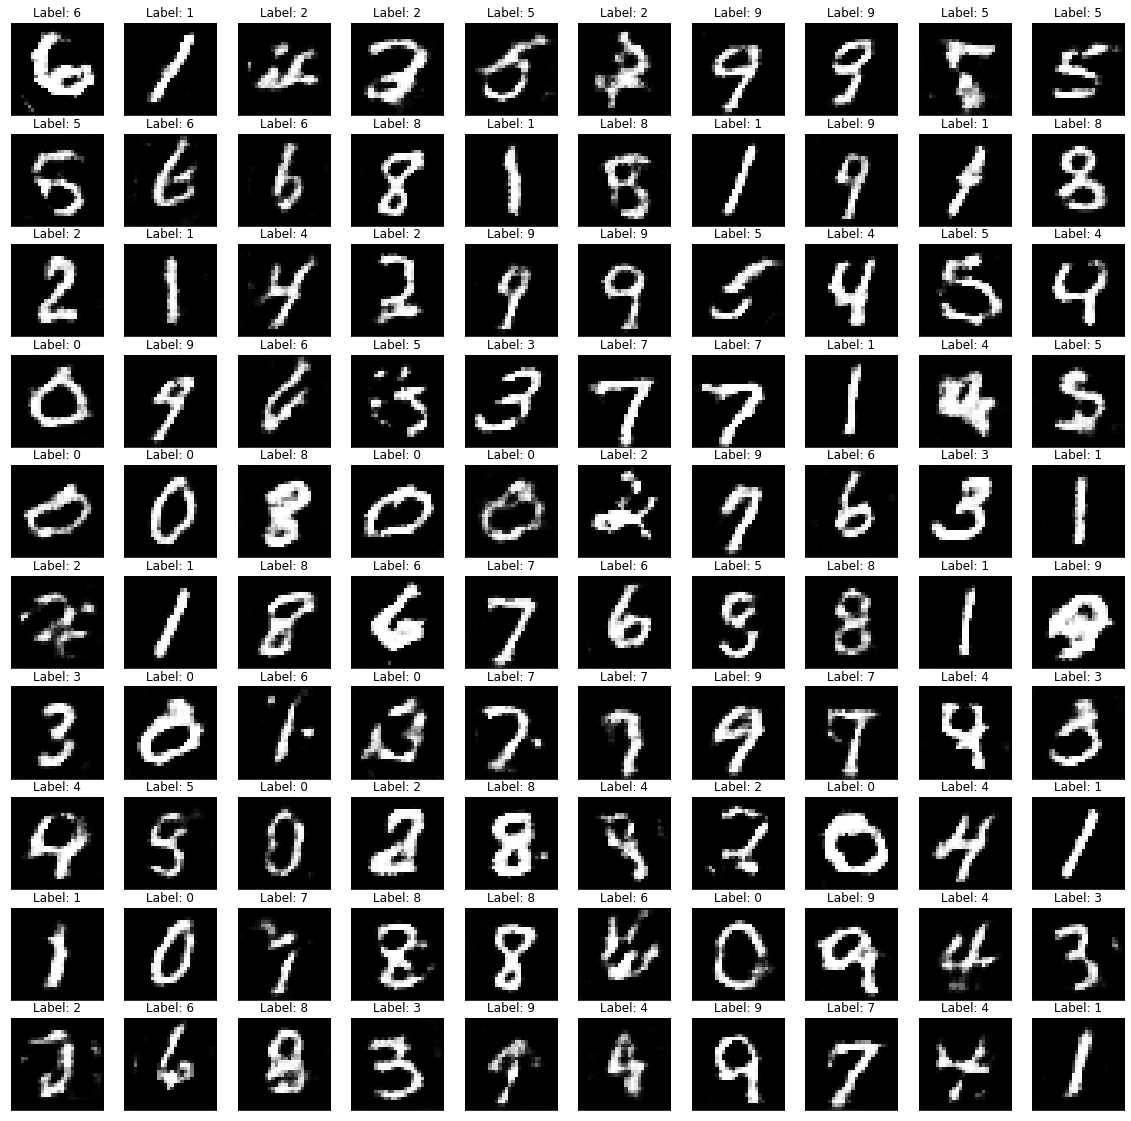

-------------------------------------------------------------------
[epoch 16], [training time 33.04]
-------------------------------------------------------------------


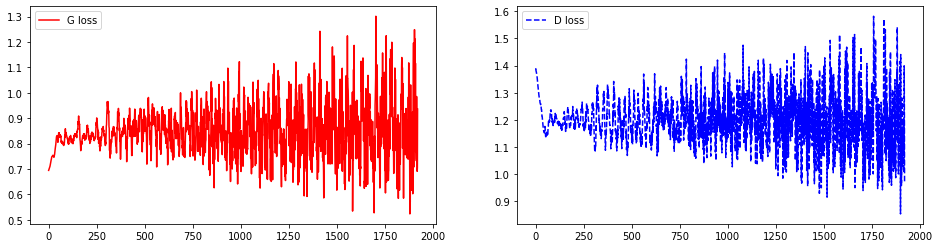

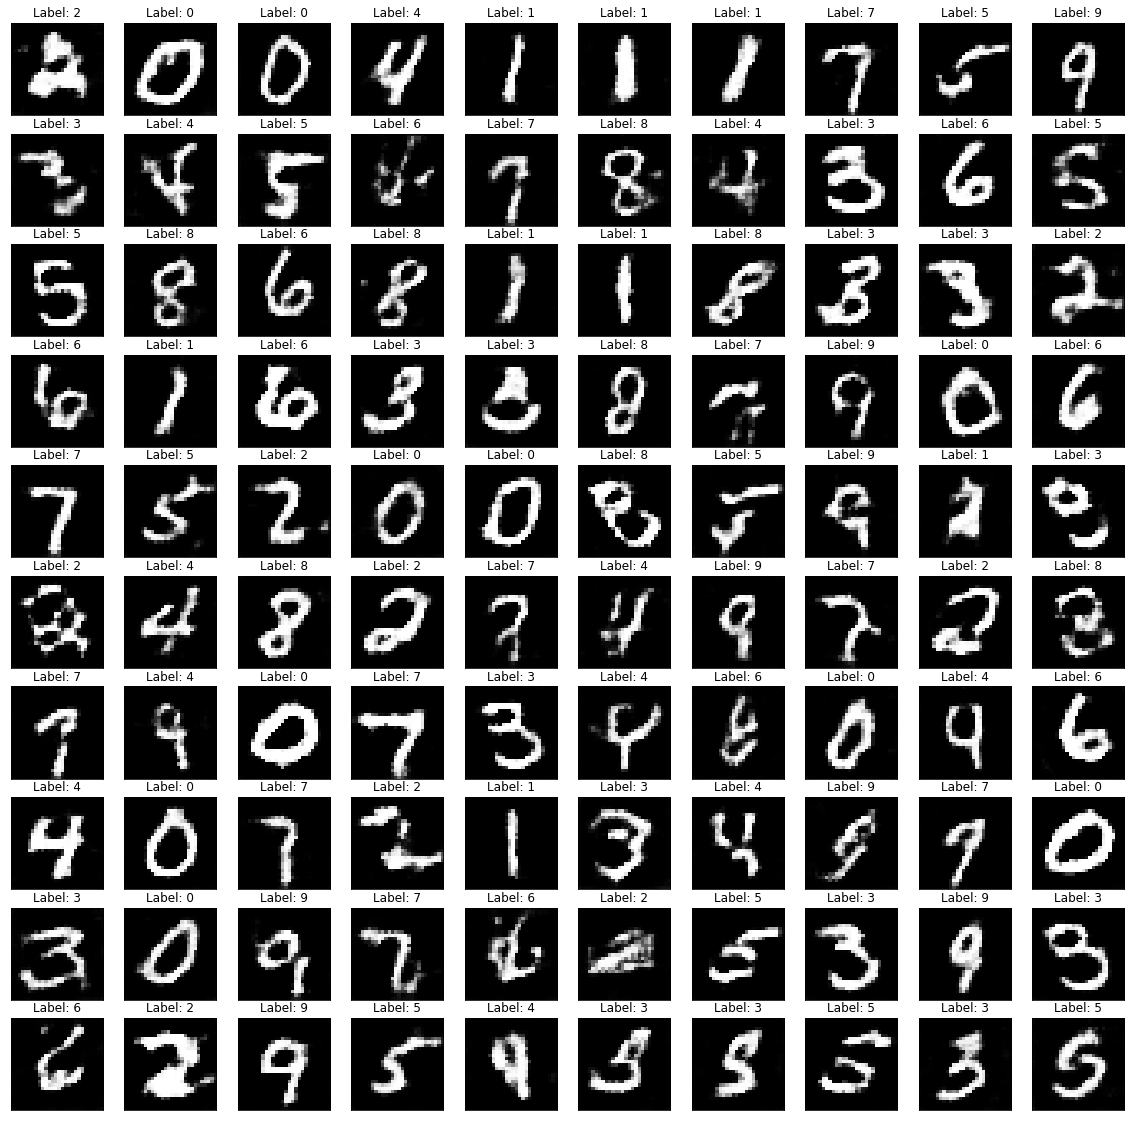

-------------------------------------------------------------------
[epoch 17], [training time 32.75]
-------------------------------------------------------------------


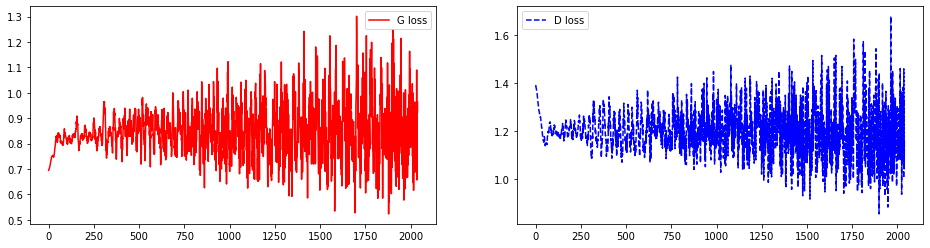

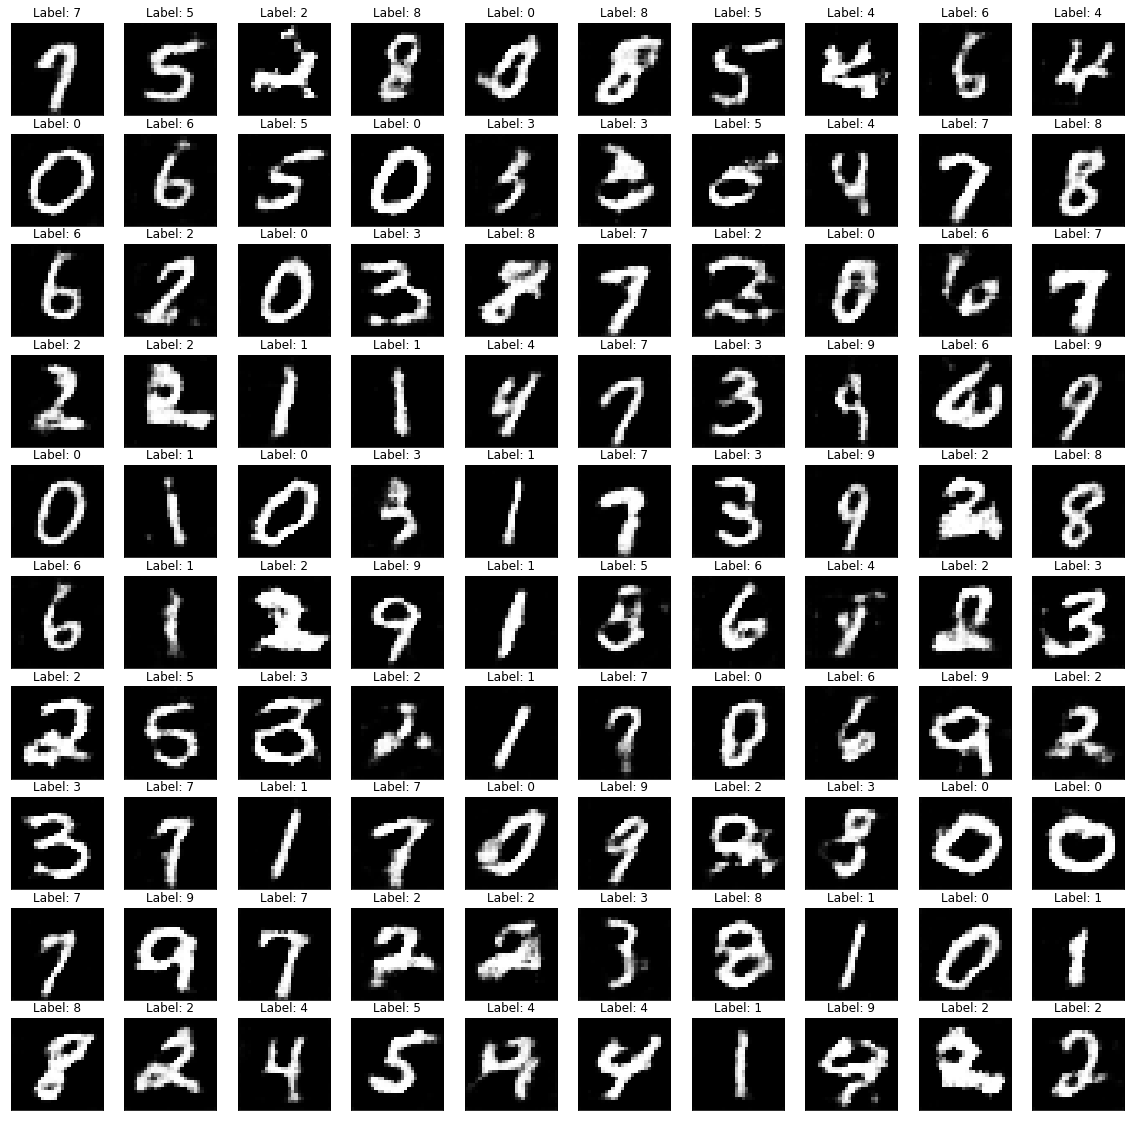

-------------------------------------------------------------------
[epoch 18], [training time 32.76]
-------------------------------------------------------------------


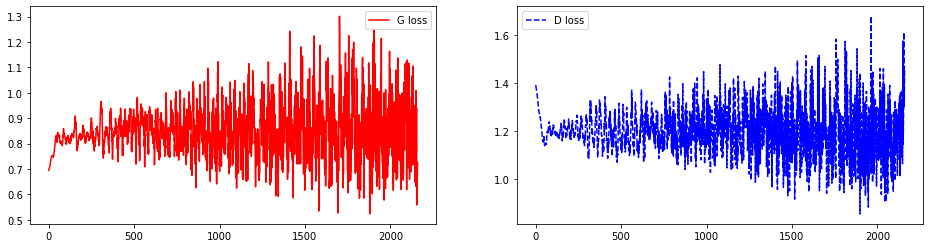

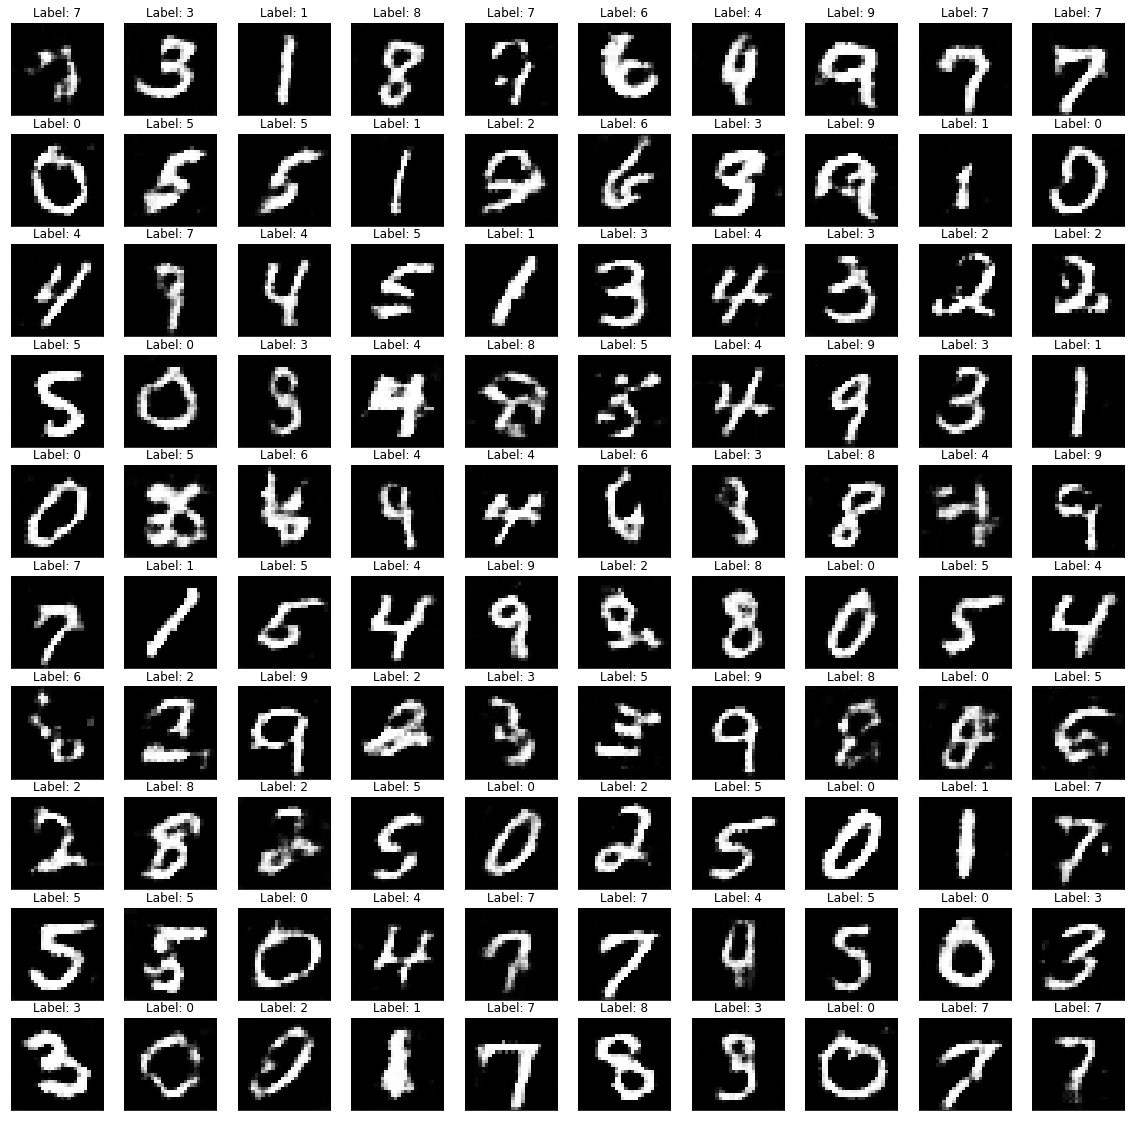

-------------------------------------------------------------------
[epoch 19], [training time 32.76]
-------------------------------------------------------------------


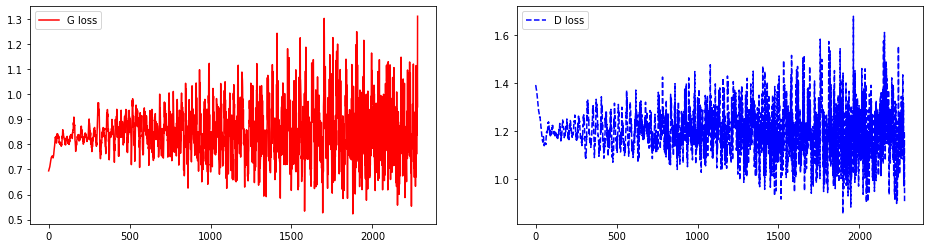

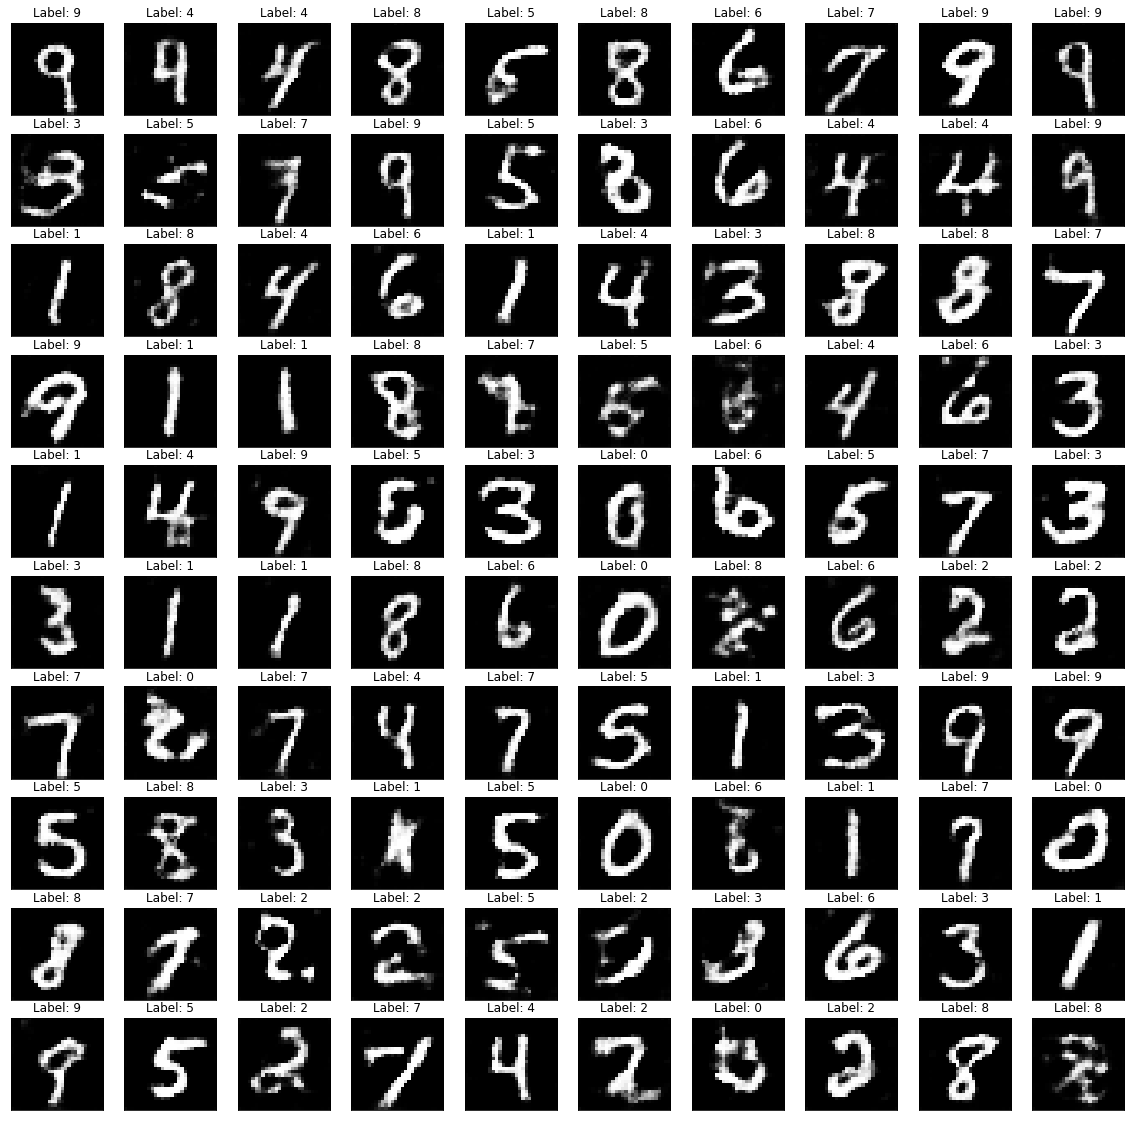

-------------------------------------------------------------------
[epoch 20], [training time 32.79]
-------------------------------------------------------------------


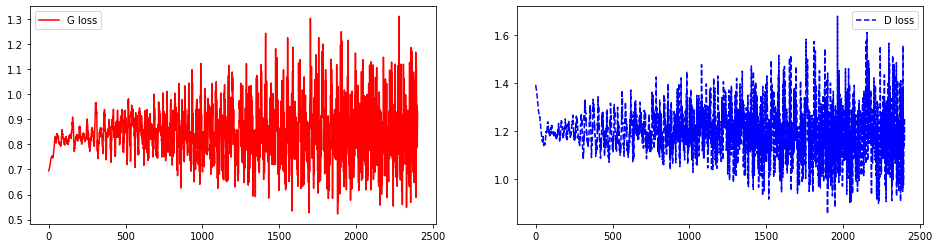

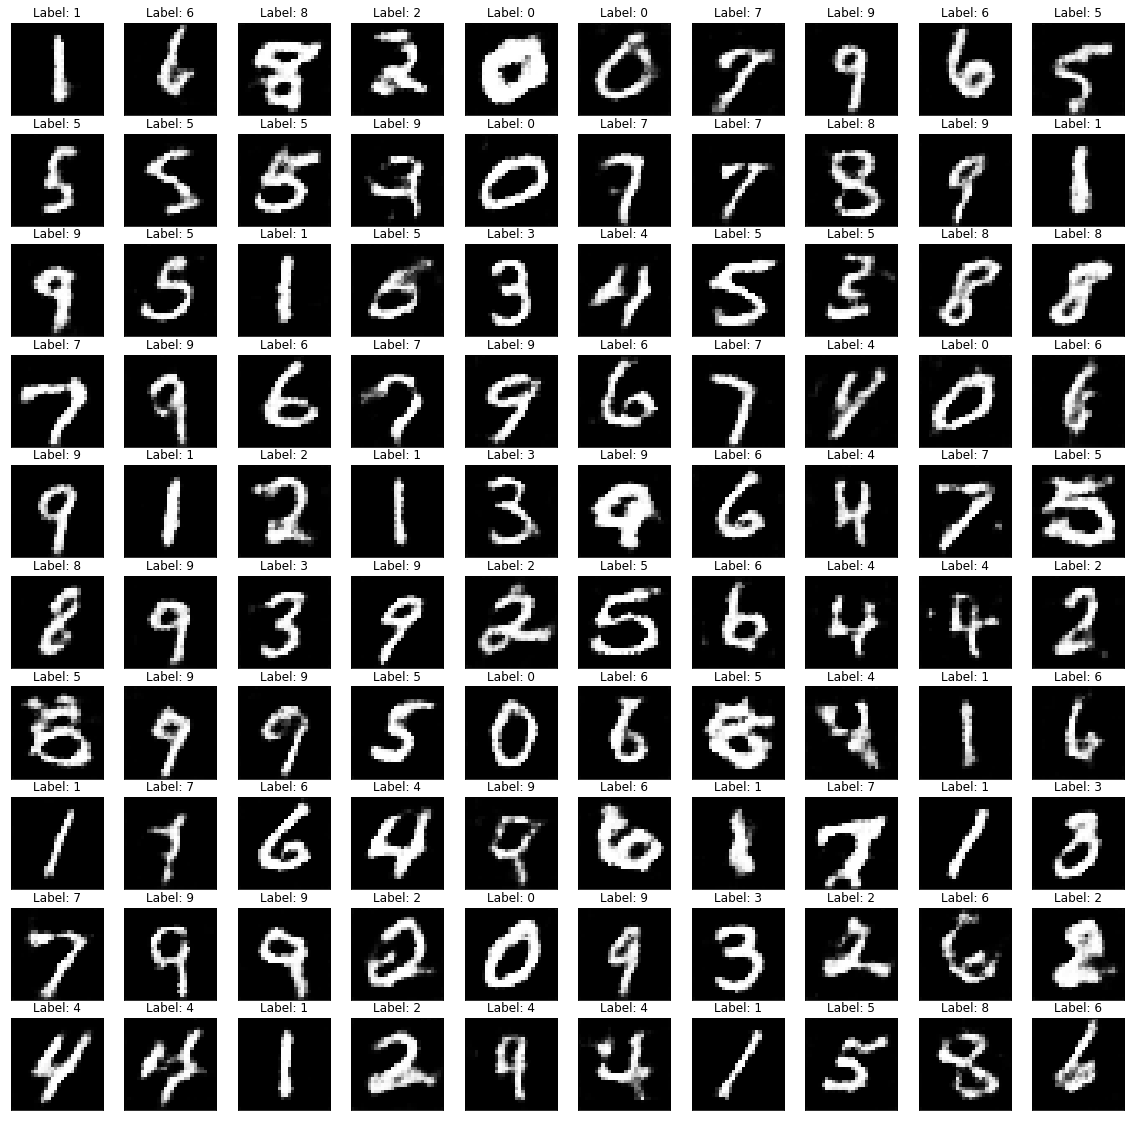

-------------------------------------------------------------------
[epoch 21], [training time 32.61]
-------------------------------------------------------------------


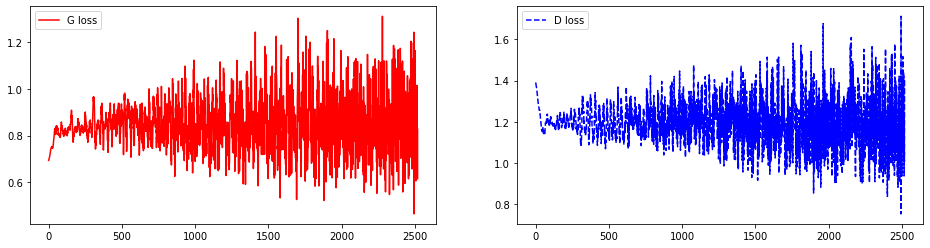

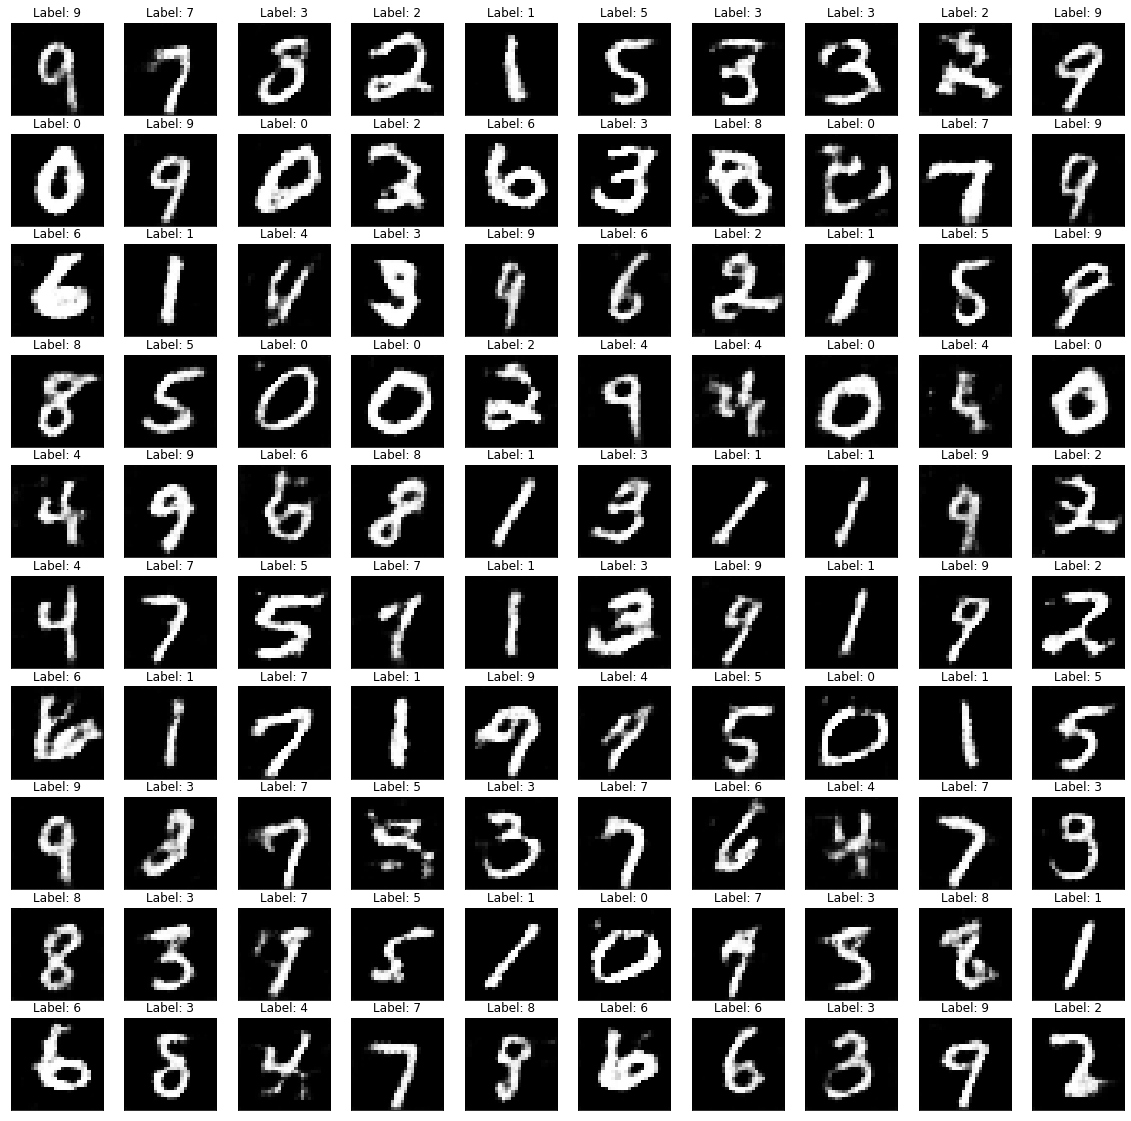

-------------------------------------------------------------------
[epoch 22], [training time 32.76]
-------------------------------------------------------------------


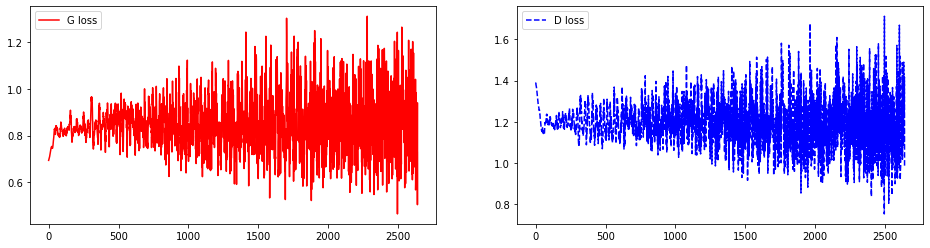

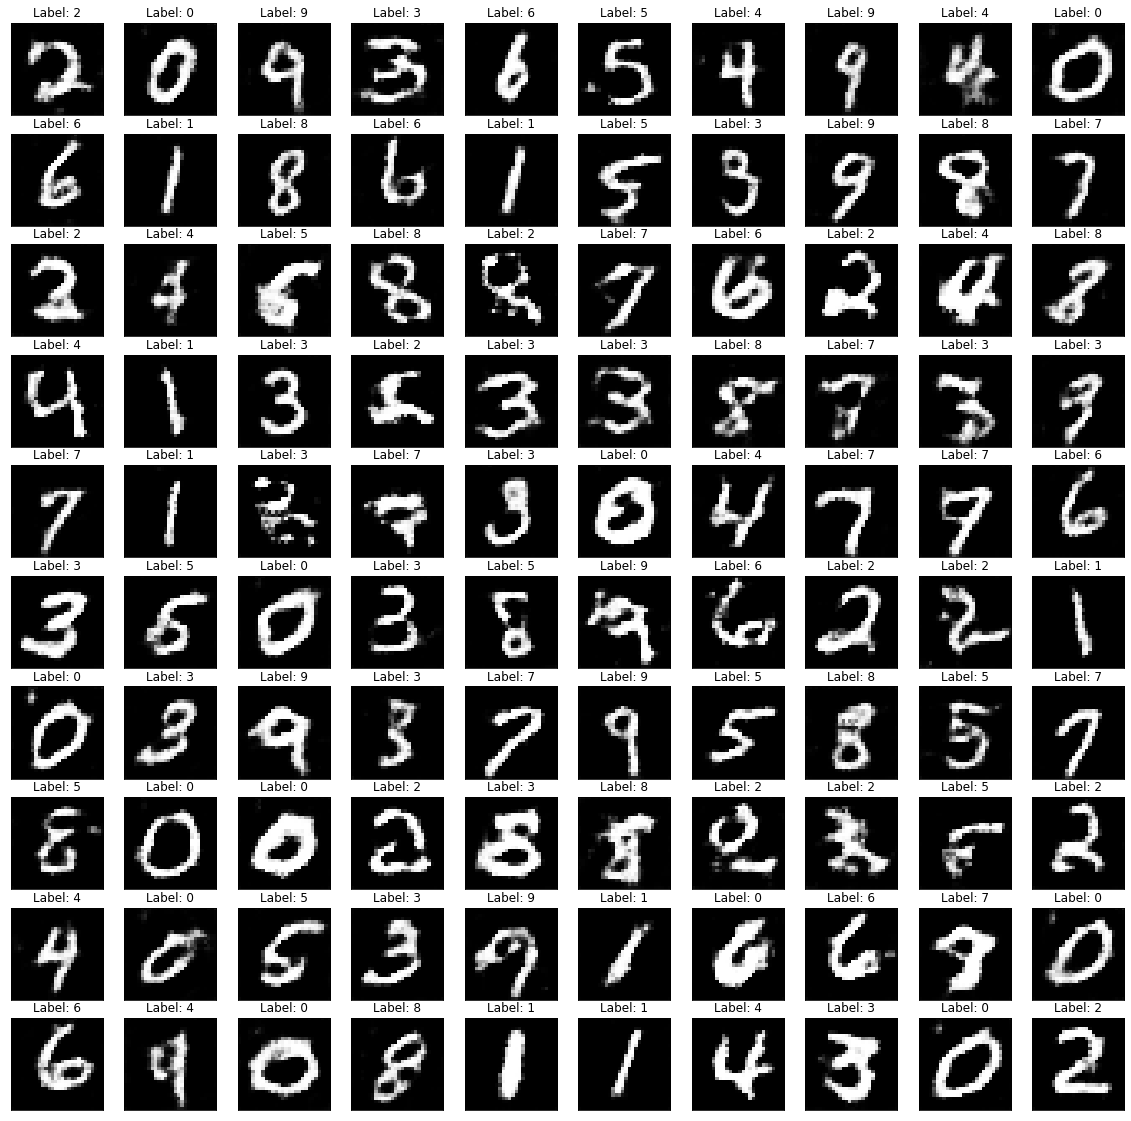

-------------------------------------------------------------------
[epoch 23], [training time 32.60]
-------------------------------------------------------------------


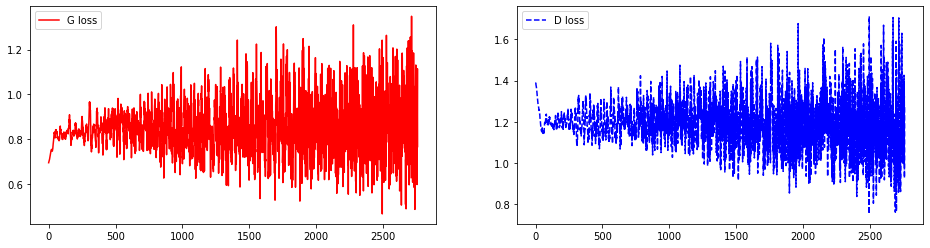

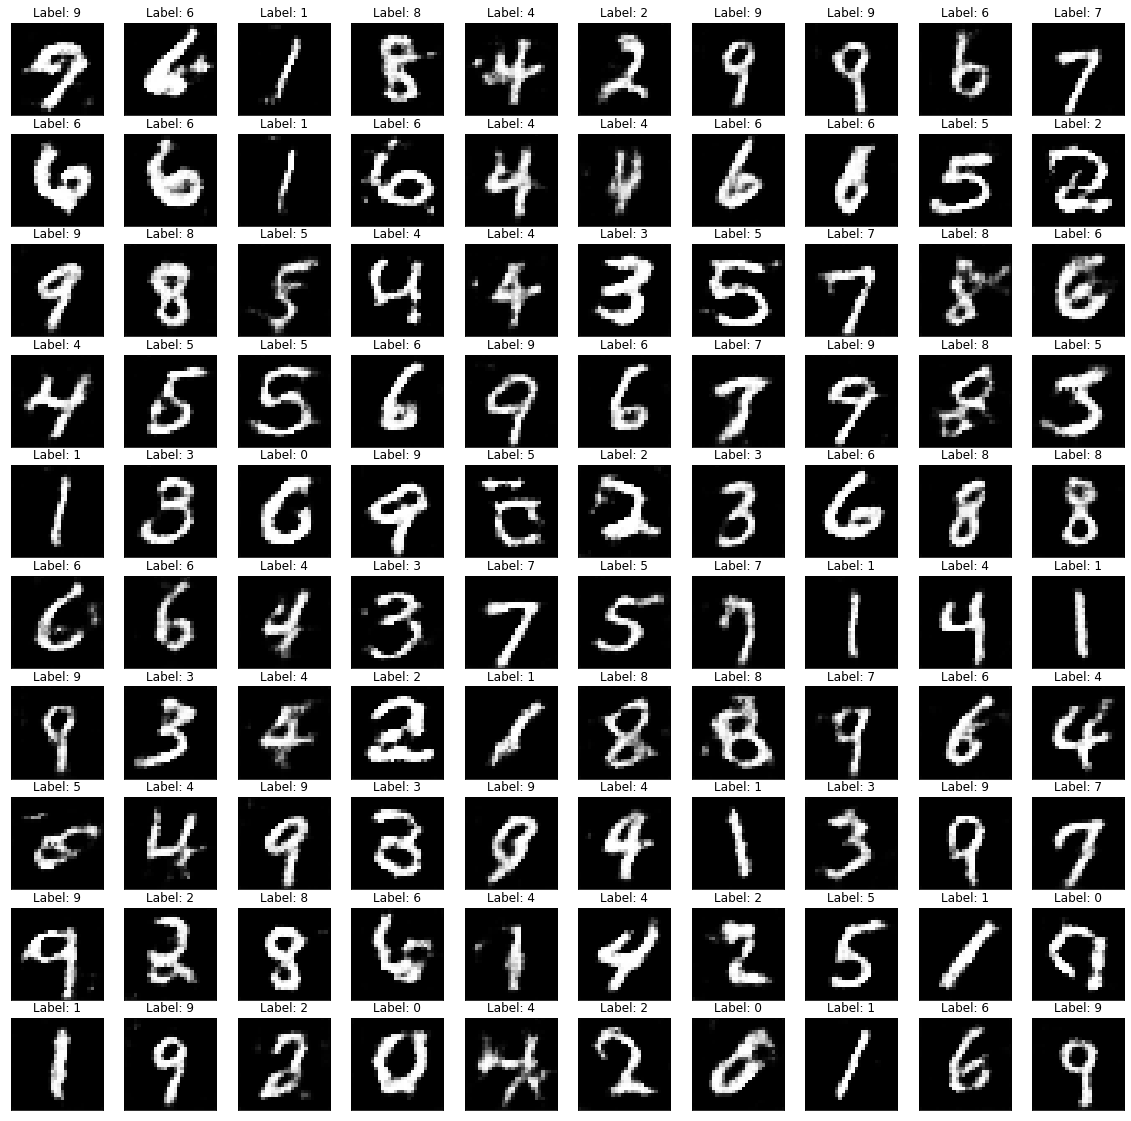

-------------------------------------------------------------------
[epoch 24], [training time 33.00]
-------------------------------------------------------------------


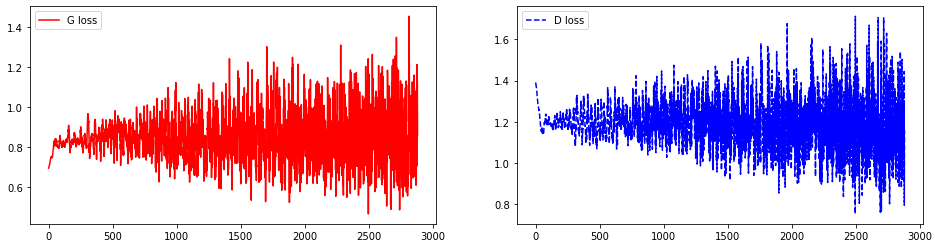

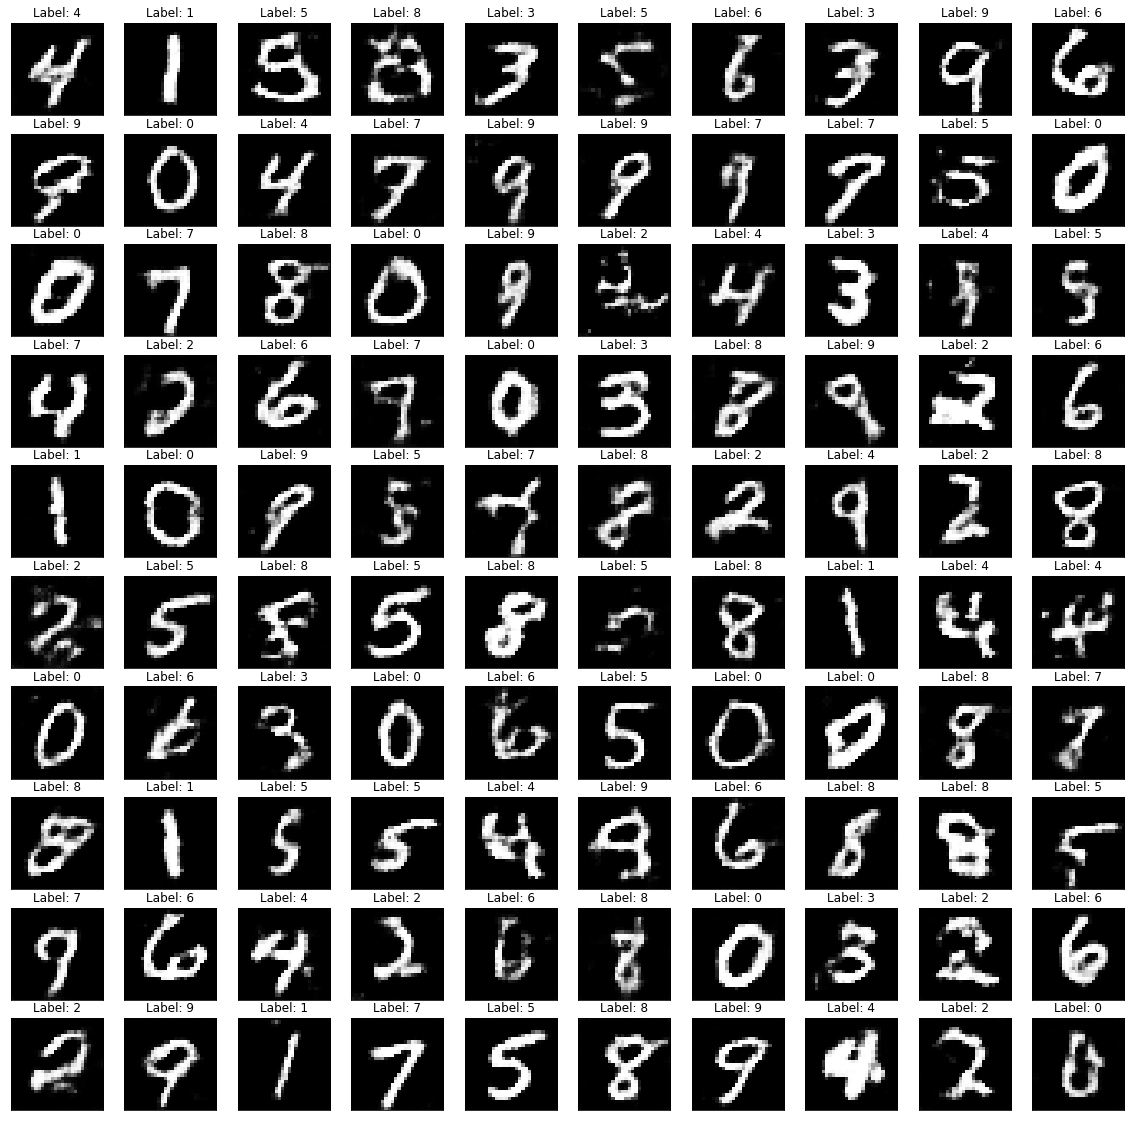

-------------------------------------------------------------------
[epoch 25], [training time 32.94]
-------------------------------------------------------------------


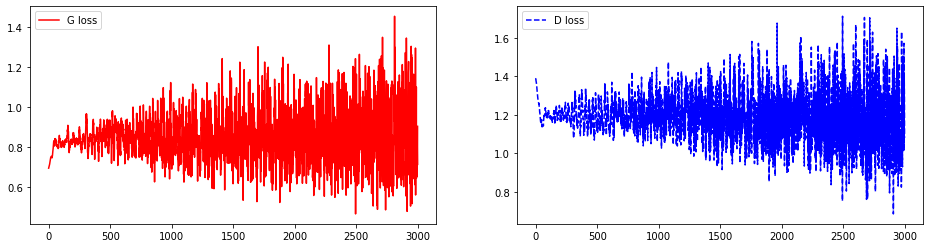

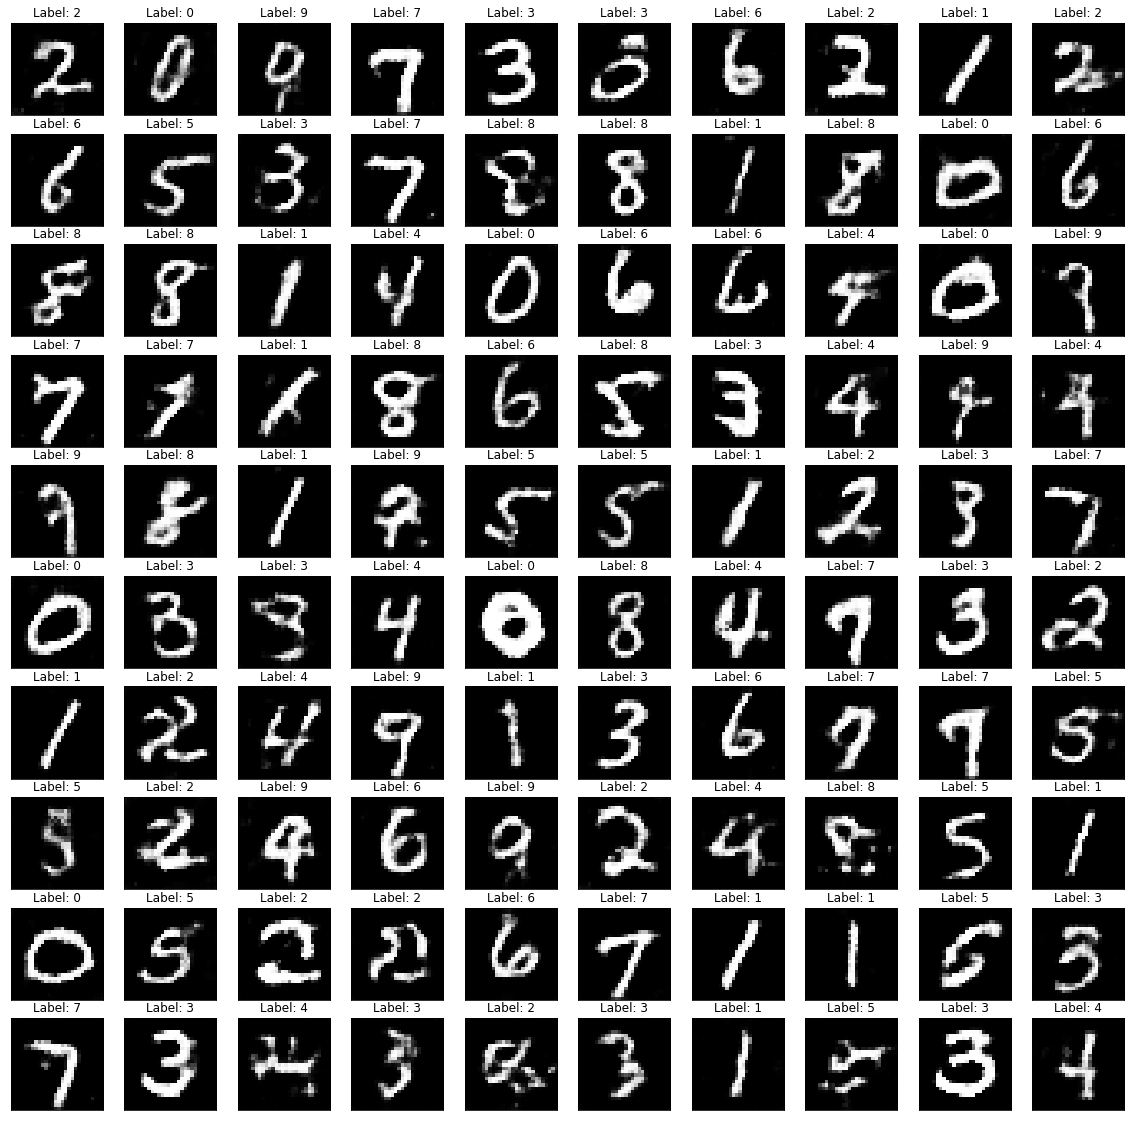

In [ ]:
# Lists for losses.
train_loss_G = []
train_loss_D = []

# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train_loss_G, train_loss_D = train(train_loader,
                                       net_G, net_D,
                                       criterion,
                                       opt_G, opt_D,
                                       epoch,
                                       train_loss_G, train_loss_D)
    
    # Taking step on scheduler.
    scheduler_G.step()
    scheduler_D.step()

    if epoch % args['print_freq'] == 0:
        
        # Testing function for sample generation.
        evaluate(net_G, criterion, epoch)